In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse
from ipywidgets import interact, widgets, fixed
from IPython.display import display
from scipy.signal import savgol_filter
import pickle
import ast
import os
import shutil
import itertools
import shap

In [2]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../packages/")
from TsIP.TsIP import TsIP
from LagsCreator.LagsCreator import LagsCreator
from NestedCV.NestedCV import NestedCV

In [3]:
# Create the folder where to store the information arising from this notebook.
dir_output_test = "./output_test"
if not os.path.exists(dir_output_test):
    os.makedirs(dir_output_test)

In [4]:
# Define the path of the folder containing the information of the hyperparameter tuning.
dir_hyper_params = "./output_hyperparameter_tuning/"
# Load the values of some global variables.
with open(dir_hyper_params + "global_variables", "rb") as f:
    COUNTRIES_TO_CONSIDER, TEST_SIZE, FRACTION_TRAIN_SET = pickle.load(f)

In [5]:
# Define variable to predict (according to the variable in the 'creator_train_test' notebook).
TARGET = "FCS"
# Define the total number of splits (according to the splits in the 'creator_train_test' notebook).
TOTAL_SPLITS = 7

In [6]:
# Define the main folder containing the training and test data.
dir_data = "./data_xgboost"

## Time-series dataset

In [7]:
# Load the data of the Yemen country.
df_yemen = pd.read_csv("../Dataset time-series/output_data/Yemen/Yemen.csv", header = [0, 1], index_col = 0)
df_yemen.index.name = "Datetime"
df_yemen.index = pd.to_datetime(df_yemen.index)
freq = "D"
df_yemen.index.freq = freq
df_yemen.columns = pd.MultiIndex.from_tuples(map(lambda x: ("Yemen", x[0], x[1]), df_yemen.columns), names = ["Country", "AdminStrata", "Indicator"])

In [8]:
# Load the data of the Syria country.
df_syria = pd.read_csv("../Dataset time-series/output_data/Syria/Syria.csv", header = [0, 1], index_col = 0)
df_syria.index.name = "Datetime"
df_syria.index = pd.to_datetime(df_syria.index)
freq = "D"
df_syria.index.freq = freq
df_syria.columns = pd.MultiIndex.from_tuples(map(lambda x: ("Syria", x[0], x[1]), df_syria.columns), names = ["Country", "AdminStrata", "Indicator"])

In [9]:
# Concatenate data.
df = pd.concat([df_yemen, df_syria], axis = 1)
# Delete the feature 'Milk and dairy' not presents for the Yemen country.
df = df.drop("Milk and dairy", axis = 1, level = 2)
# Consider the following dates.
df = df.loc["2018-01-01":"2020-08-31"]

In [10]:
# Select countries.
df = df[COUNTRIES_TO_CONSIDER]
df.head()

Country                            Yemen                                \
AdminStrata                        Abyan                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2018-01-01                           NaN                           NaN   
2018-01-02                           NaN                           NaN   
2018-01-03                           NaN                           NaN   
2018-01-04                           NaN                           NaN   
2018-01-05                           NaN                           NaN   

Country                                                              \
AdminStrata                                                           
Indicator   Cereals and tubers Code Exchange rate FCS Fatality Fuel   
Datetime                                                              
2018-01-01                 NaN   65           NaN NaN      NaN  NaN   
2018-01-02                 NaN   65           NaN NaN      NaN  NaN   
2018-01-03                 NaN   65           NaN NaN      NaN  NaN   
2018-01-04                 NaN   65           NaN NaN      NaN  NaN   
2018-01-05                 NaN   65           NaN NaN      NaN  NaN   

Country                            ...                                  \
AdminStrata                        ... Taizz                             
Indicator          Lat        Lon  ...  NDVI NDVI Anomaly Oil and fats   
Datetime                           ...                                   
2018-01-01   13.704878  46.158142  ...   NaN          NaN          NaN   
2018-01-02   13.704878  46.158142  ...   NaN          NaN          NaN   
2018-01-03   13.704878  46.158142  ...   NaN          NaN          NaN   
2018-01-04   13.704878  46.158142  ...   NaN          NaN          NaN   
2018-01-05   13.704878  46.158142  ...   NaN          NaN          NaN   

Country                                                       \
AdminStrata                                                    
Indicator   Population Pulses and nuts Rainfall (mm) Ramadan   
Datetime                                                       
2018-01-01     3065034             NaN           NaN     NaN   
2018-01-02     3065034             NaN           NaN     NaN   
2018-01-03     3065034             NaN           NaN     NaN   
2018-01-04     3065034             NaN           NaN     NaN   
2018-01-05     3065034             NaN           NaN     NaN   

Country                                      
AdminStrata                                  
Indicator   Vegetables and fruits Wage rCSI  
Datetime                                     
2018-01-01                    NaN  NaN  NaN  
2018-01-02                    NaN  NaN  NaN  
2018-01-03                    NaN  NaN  NaN  
2018-01-04                    NaN  NaN  NaN  
2018-01-05                    NaN  NaN  NaN  

[5 rows x 440 columns]

In [11]:
# Plot time-series.
#TsIP(df).interactive_plot_df(title = "Time-series", matplotlib = False, style = "lines", comparison = False)

## Nested cross validation/test

In [12]:
# Create the nested cross validation.
cv = NestedCV(TOTAL_SPLITS, TEST_SIZE)

In [13]:
# Total nested cross validation.
SPLITS = cv.get_splits(df)

In [14]:
for split_number, (train, test) in SPLITS.items():
    print("Split %d: range of days to predict between %s - %s" % (split_number, str(test.index[0].date()), str(test.index[-1].date())))

Split 1: range of days to predict between 2020-02-01 - 2020-03-01
Split 2: range of days to predict between 2020-03-01 - 2020-03-30
Split 3: range of days to predict between 2020-04-01 - 2020-04-30
Split 4: range of days to predict between 2020-05-01 - 2020-05-30
Split 5: range of days to predict between 2020-06-01 - 2020-06-30
Split 6: range of days to predict between 2020-07-01 - 2020-07-30
Split 7: range of days to predict between 2020-08-01 - 2020-08-30


## Hyper-parameters tuning results

In [15]:
hyper_params = pd.read_csv(dir_hyper_params + "hyperparameter_tuning.csv")
hyper_params

,1 Month Anomaly (%) Rainfall,Cereals and tubers,Code,Day,Dayofweek,Exchange rate,FCS,Fatality,Month,NDVI Anomaly,...,h,split,train_loss,val_loss,r2_train,r2_val,shape_train,shape_val,r2_difference,loss_to_minimize
0,0,0,1,1,1,0,1,0,1,0,...,1,1,0.956700,1.475536,0.991790,0.986484,"(8440, 19)","(160, 19)",0.005306,0.006177
1,0,1,1,1,1,1,1,1,1,0,...,1,1,1.307796,1.326175,0.988777,0.987853,"(8440, 26)","(160, 26)",0.000925,0.004014
2,0,0,1,1,1,1,1,0,1,1,...,1,1,1.488462,1.516986,0.987227,0.986105,"(8440, 28)","(160, 28)",0.001122,0.004617
3,0,0,1,1,1,1,1,1,1,0,...,1,1,1.414908,1.410930,0.987858,0.987076,"(8440, 26)","(160, 26)",0.000782,0.004190
4,0,0,1,1,1,0,1,0,1,0,...,1,1,1.228295,1.447805,0.989459,0.986738,"(8440, 21)","(160, 21)",0.002721,0.005067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63385,0,1,1,1,1,0,1,1,1,0,...,30,7,18.580118,27.658372,0.831415,0.691064,"(11180, 27)","(200, 27)",0.140351,0.148821
63386,0,0,1,1,1,0,1,1,1,1,...,30,7,8.264383,37.908732,0.925014,0.576570,"(11180, 26)","(200, 26)",0.348444,0.266406
63387,0,1,1,1,1,0,1,1,1,0,...,30,7,9.196792,33.766348,0.916554,0.622840,"(11180, 26)","(200, 26)",0.293714,0.230634
63388,1,1,1,1,1,0,1,1,1,0,...,30,7,21.398733,29.063249,0.805841,0.675372,"(11180, 28)","(200, 28)",0.130469,0.149576


In [16]:
# Find the best attempt for each prediction horizon over each split.
metric = "loss_to_minimize"

def fmin(group):
    return group[metric].idxmin()

result = hyper_params.groupby(["split", "h"]).apply(fmin)

In [17]:
best_result = hyper_params.loc[result].set_index(["split", "h"])
best_result

1 Month Anomaly (%) Rainfall  Cereals and tubers  Code  Day  \
split h                                                                 
1     1                              0                   1     1    1   
      2                              0                   1     1    1   
      3                              0                   1     1    1   
      4                              0                   1     1    1   
      5                              1                   1     1    1   
...                                ...                 ...   ...  ...   
7     26                             0                   1     1    1   
      27                             0                   1     1    1   
      28                             0                   1     1    1   
      29                             0                   0     1    1   
      30                             0                   1     1    1   

          Dayofweek  Exchange rate  FCS  Fatality  Month  NDVI Anomaly  ...  \
split h                                                                 ...   
1     1           1              1    1         0      1             0  ...   
      2           1              1    1         1      1             1  ...   
      3           1              0    1         0      1             0  ...   
      4           1              0    1         0      1             1  ...   
      5           1              1    1         0      1             1  ...   
...             ...            ...  ...       ...    ...           ...  ...   
7     26          1              0    1         1      1             1  ...   
      27          1              0    1         0      1             0  ...   
      28          1              0    1         0      1             0  ...   
      29          1              0    1         0      1             1  ...   
      30          1              0    1         1      1             0  ...   

          subsample  attempt  train_loss   val_loss  r2_train    r2_val  \
split h                                                                   
1     1        0.65      166    1.389702   1.313211  0.988074  0.987971   
      2        0.60      167    3.039048   2.919395  0.973888  0.973259   
      3        0.85      275    3.693672   3.630644  0.968223  0.966744   
      4        0.75      210    5.787274   5.720081  0.950158  0.947606   
      5        0.75      240    7.189102   7.794715  0.938022  0.928603   
...             ...      ...         ...        ...       ...       ...   
7     26       0.85      244   17.802210  23.424984  0.838656  0.738350   
      27       0.75      247   21.226917  22.344003  0.807538  0.750424   
      28       0.75      199   19.235991  22.538722  0.825534  0.748249   
      29       0.95      244   24.956516  26.113563  0.773593  0.708319   
      30       0.60      107   18.590024  22.904115  0.831325  0.744168   

          shape_train  shape_val  r2_difference  loss_to_minimize  
split h                                                            
1     1    (8440, 23)  (160, 23)       0.000103          0.003650  
      2    (8420, 31)  (160, 31)       0.000629          0.008274  
      3    (8400, 21)  (160, 21)       0.001478          0.010568  
      4    (8380, 26)  (160, 26)       0.002552          0.016739  
      5    (8360, 32)  (160, 32)       0.009419          0.025187  
...               ...        ...            ...               ...  
7     26  (11260, 28)  (200, 28)       0.100307          0.118618  
      27  (11240, 23)  (200, 23)       0.057114          0.097718  
      28  (11220, 21)  (200, 21)       0.077285          0.106439  
      29  (11200, 21)  (200, 21)       0.065274          0.113614  
      30  (11180, 26)  (200, 26)       0.087158          0.111613  

[210 rows x 33 columns]

In [18]:
def plot_r2_box_plot(data_train, data_test, ax, label_train = None, label_test = None, title = None, table_train = None, 
                     color_train = "#355269", color_test = "#5eb91e"):
    # Define x-ticks.
    x_ticks = np.arange(1, data_train.shape[1] + 1)
    medianprops = dict(linestyle = "-", linewidth = 2.5)
    # Boxplot.
    bptrain = ax.boxplot(data_train, positions = x_ticks*2.0 - 0.4, sym = "", widths = 0.6, medianprops = medianprops)
    bptest = ax.boxplot(data_test, positions = x_ticks*2.0 + 0.4, sym = "", widths = 0.6, medianprops = medianprops, manage_ticks = False)

    # Draw temporary lines for legend.
    ax.plot([], c = color_train, label = label_train)
    ax.plot([], c = color_test, label = label_test)
    ax.legend(loc = "best", prop = {"size": 15})
    
    # Set attributes of the plot.
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel("Prediction horizon", fontsize = 15)
    ax.set_ylabel("R$^2$", fontsize = 15)
    ax.set_ylim([0, 1])
    ax.tick_params(labeltop = False, labelright = True)
    ax.set_xticks(ax.get_xticks() + 0.5)
    ax.set_xticklabels(x_ticks)  
    
    ax.set_xlim([0, ax.get_xticks()[-1] + 1.8])
    
    # Insert information table.
    if table_train is not None:
        ax.table(cellText = table_train.values, rowLabels = table_train.index, colLabels = table_train.columns,
                 bbox = [0.0, -0.55, 1, .28], loc = "bottom")

    def set_box_color(bp, color):
        plt.setp(bp["boxes"], color = color)
        plt.setp(bp["whiskers"], color = color)
        plt.setp(bp["caps"], color = color)
        plt.setp(bp["medians"], color = color)

    # Set the colors of the boxplots.
    set_box_color(bptrain, color_train) 
    set_box_color(bptest, color_test)

    # Add boxplots to the axis.
    ax = bptrain
    ax = bptest

    return ax

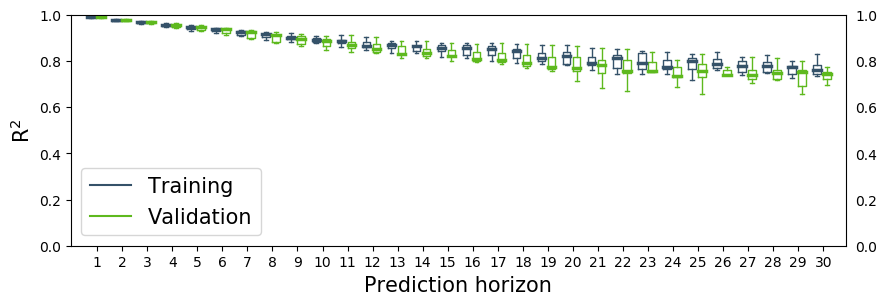

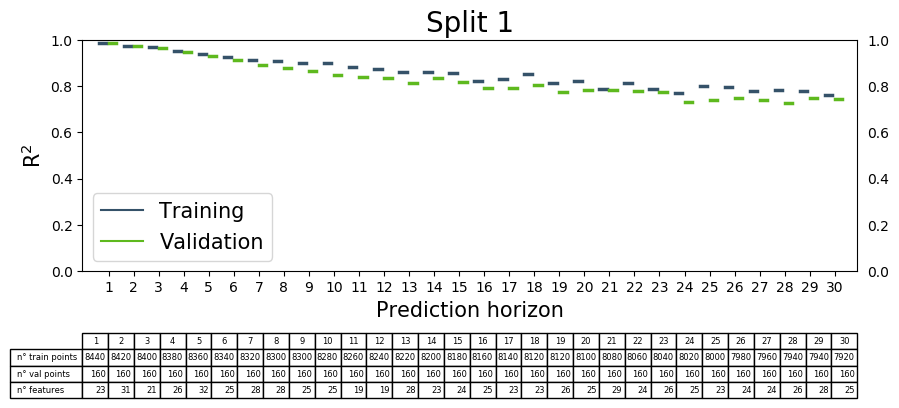

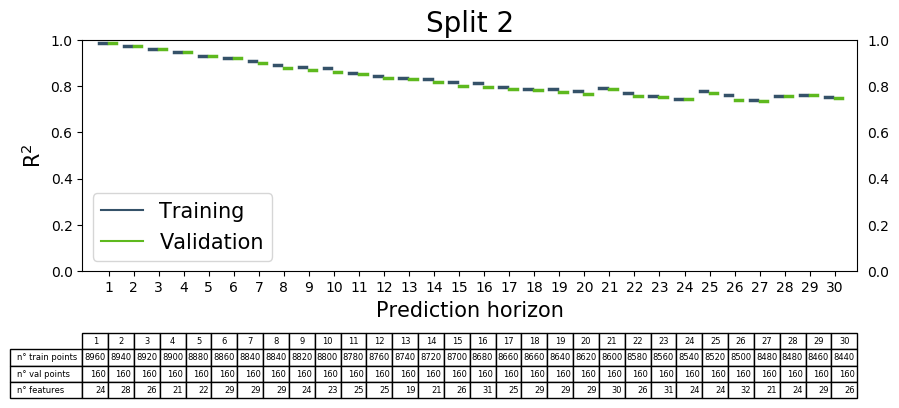

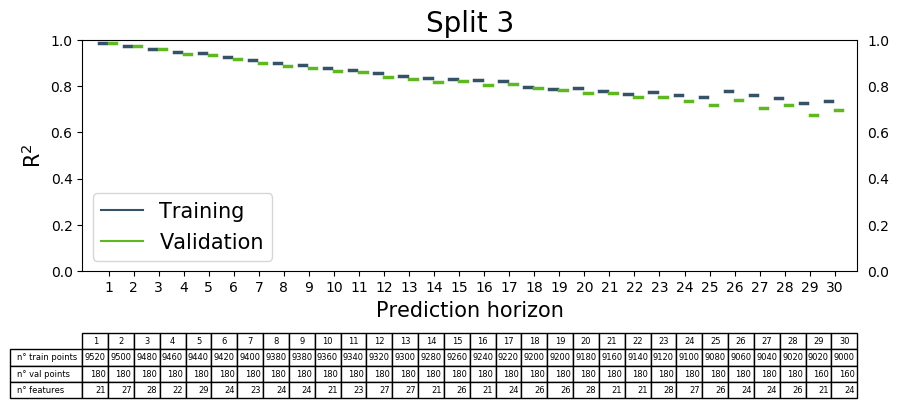

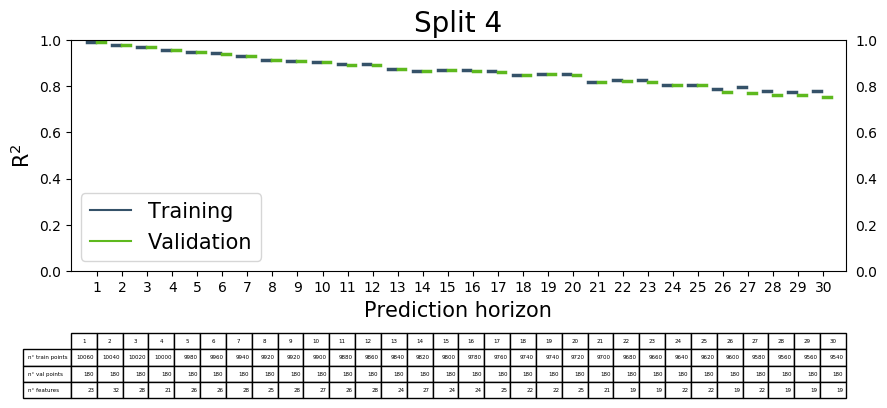

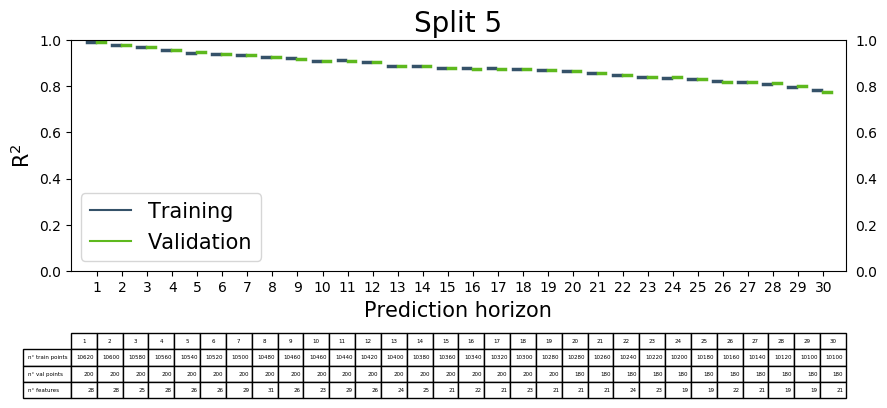

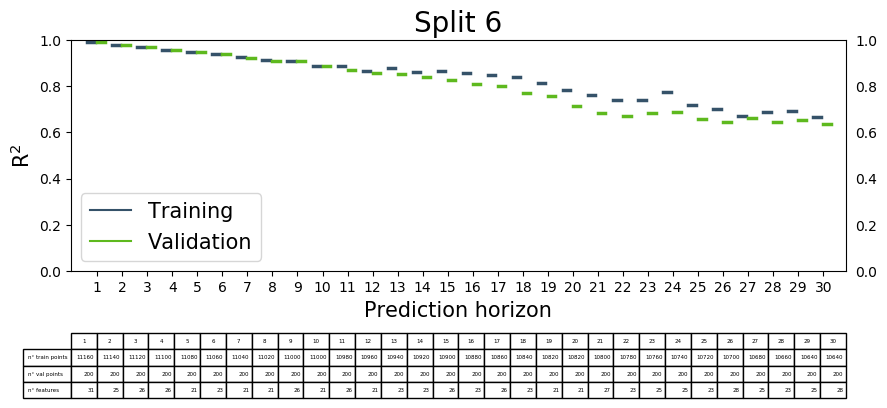

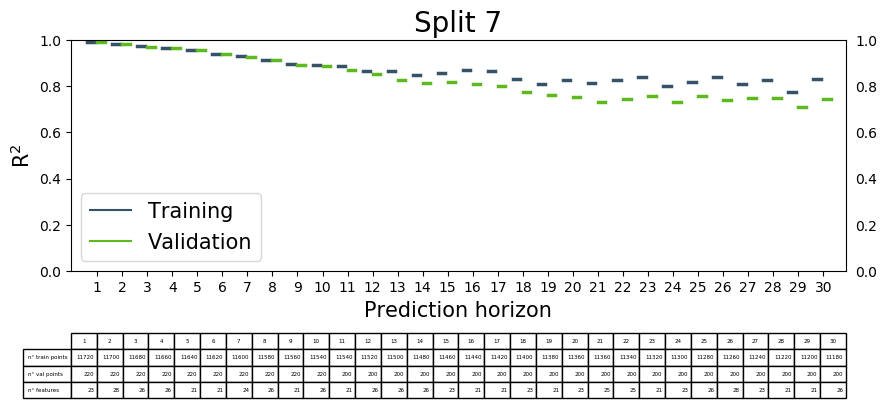

In [19]:
# Create folder where to save results of the hyperparameter tuning.
dir_results_hyperparameter_tuning = dir_output_test + "/hyperparameter_tuning"

if os.path.exists(dir_results_hyperparameter_tuning):
    shutil.rmtree(dir_results_hyperparameter_tuning)
    os.makedirs(dir_results_hyperparameter_tuning)
else:
    os.makedirs(dir_results_hyperparameter_tuning)

with plt.style.context("default"):
    # Get the information of the r2 train for each prediction horizon considering the split information together.
    data_train = best_result[["r2_train"]].unstack().transpose()
    # Get the information of the r2 validation for each prediction horizon considering the split information together.
    data_validation = best_result[["r2_val"]].unstack().transpose()

    # Plot the box-plot.
    fig, axs = plt.subplots(figsize = (10, 3))
    plot_r2_box_plot(data_train.values.T, data_validation.values.T, axs, label_train = "Training", label_test = "Validation", 
                     color_train = "#355269", color_test = "#5eb91e")
    fig.savefig(dir_results_hyperparameter_tuning + "/all_splits.png", bbox_inches = "tight", dpi = 300)

    for i,split_number in enumerate(best_result.index.get_level_values(0).unique()):
        # Create dataframe/table with information about the train and validation shapes.
        table_train = best_result.loc[split_number][["shape_train", "shape_val"]].applymap(lambda x: ast.literal_eval(x))
        table_train["shape"] = table_train.apply(lambda x: (x.shape_train[0], x.shape_val[0], x.shape_train[1]), axis = 1)
        table_train = table_train["shape"].to_dict()
        table_train = pd.DataFrame(table_train, index = ["n° train points", "n° val points", "n° features"])
        # Plot the box-plot.
        fig, axs = plt.subplots(figsize = (10, 3))
        plot_r2_box_plot(data_train[[split_number]].values.T, data_validation[[split_number]].values.T, axs, 
                         label_train = "Training", label_test = "Validation", title = "Split %d" % split_number, 
                         table_train = table_train, color_train = "#355269", color_test = "#5eb91e")
        fig.savefig(dir_results_hyperparameter_tuning + "/split_%d.png" % split_number, bbox_inches = "tight", dpi = 300)

In [20]:
def recursive_improvement(x):
    list_improvements = list()

    for i,value in enumerate(x):
        if i == 0:
            best_min = value
        else:
            if best_min > value:
                diff = best_min - value
                best_min = value
                list_improvements.append(diff)
            else:
                list_improvements.append(0)
            
    return list_improvements

In [21]:
def f_recursive_improvement(x):
    x = x.to_list()
    return recursive_improvement(x)

hyper_params_recursive = hyper_params.set_index(["split", "h"])["loss_to_minimize"].groupby(axis = 0, level = [0, 1]).apply(f_recursive_improvement)

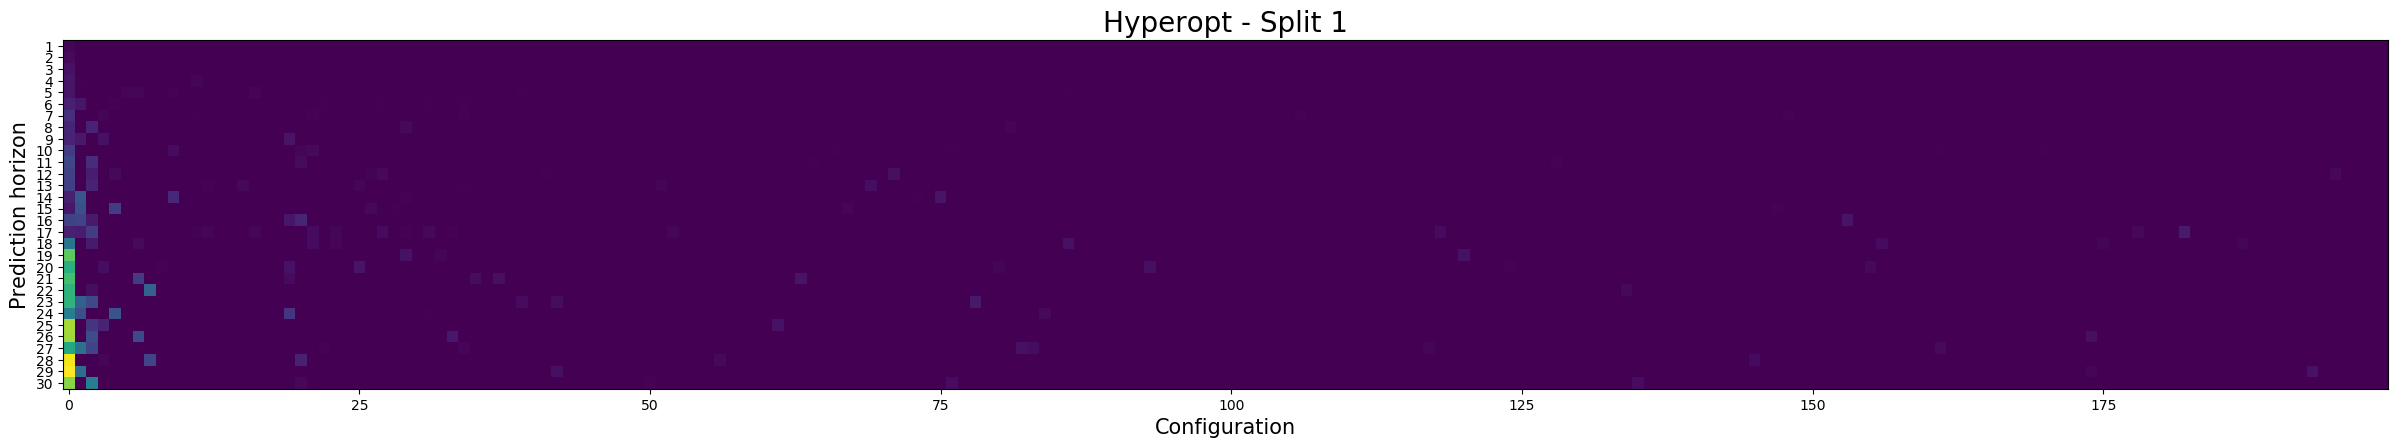

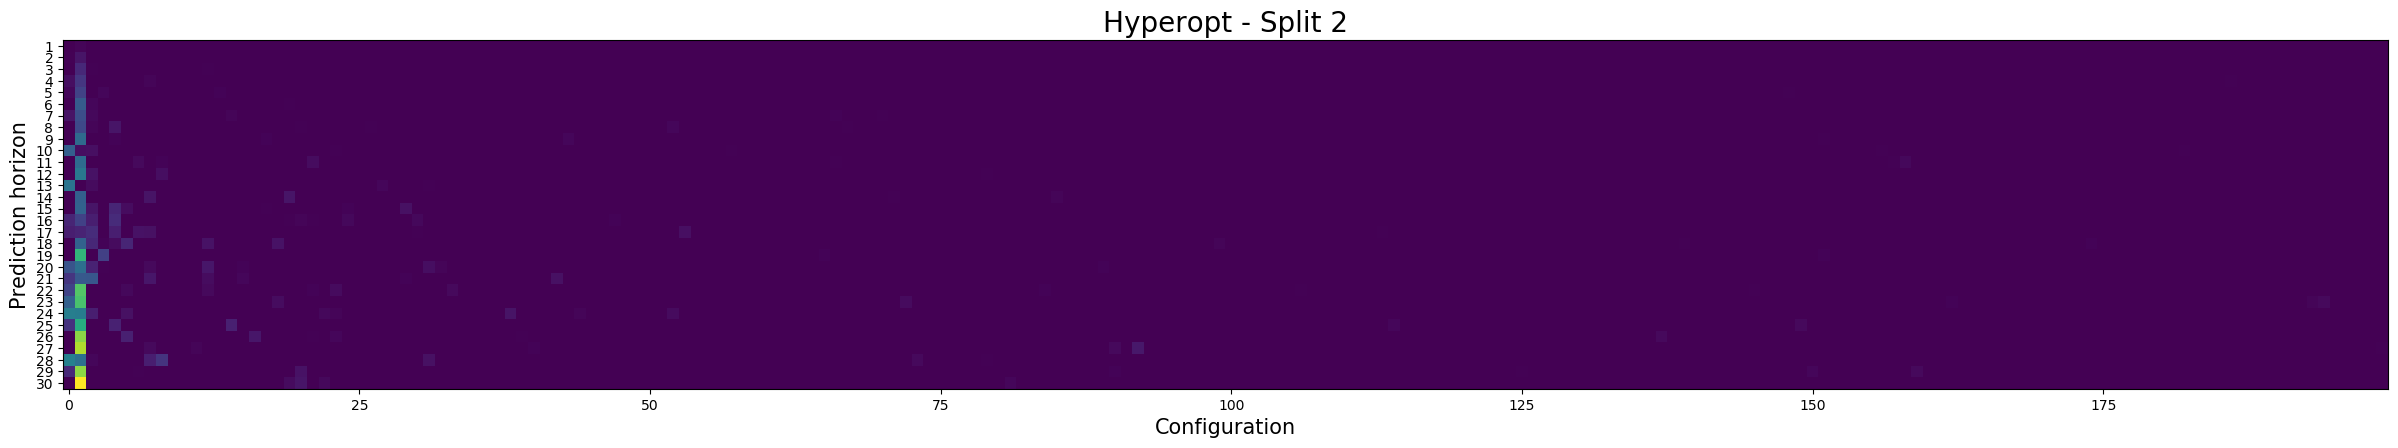

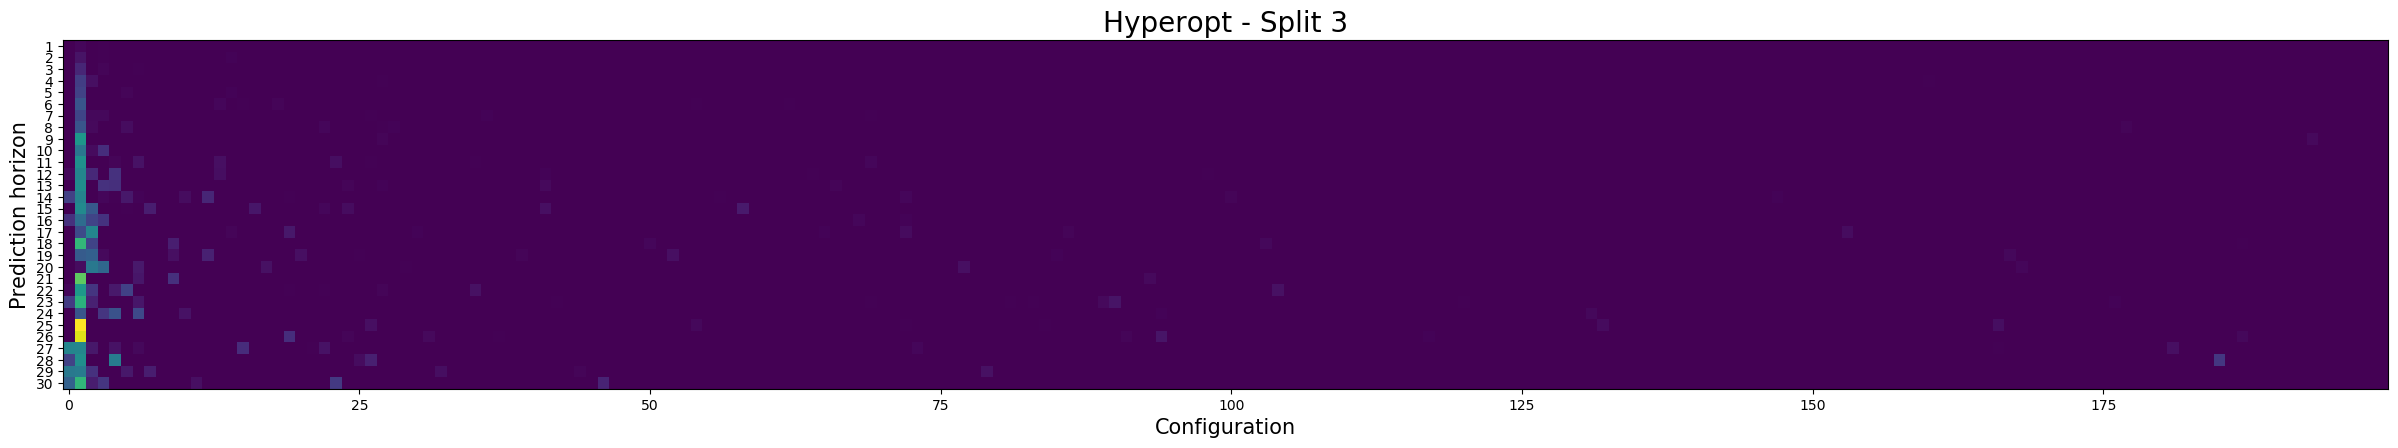

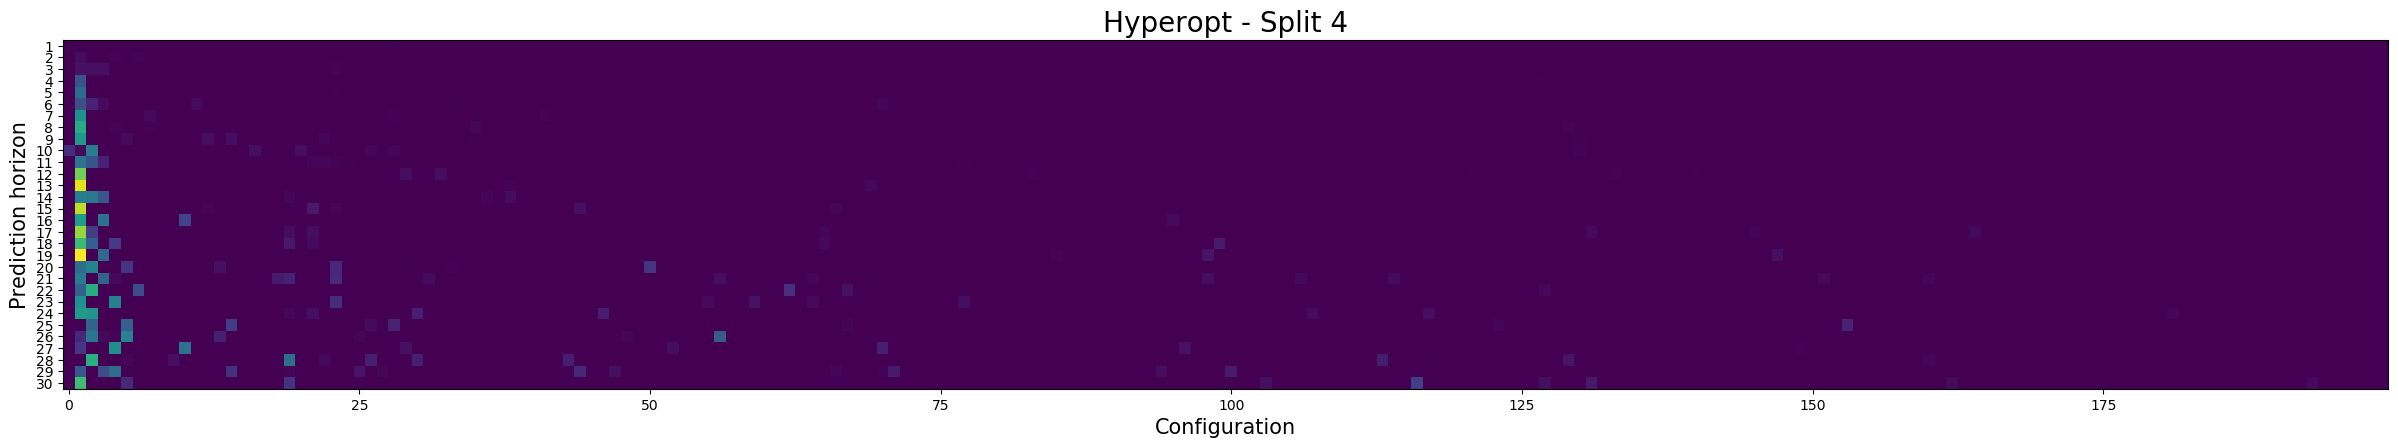

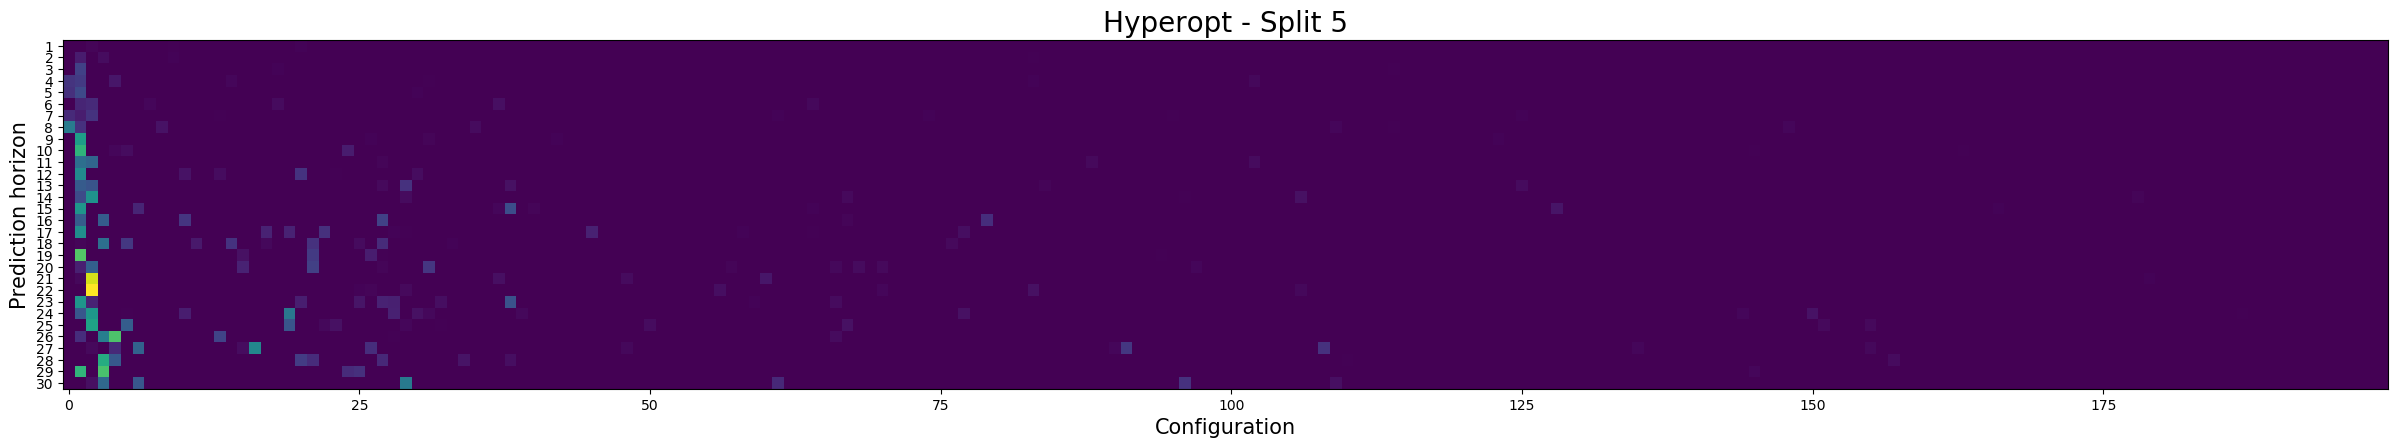

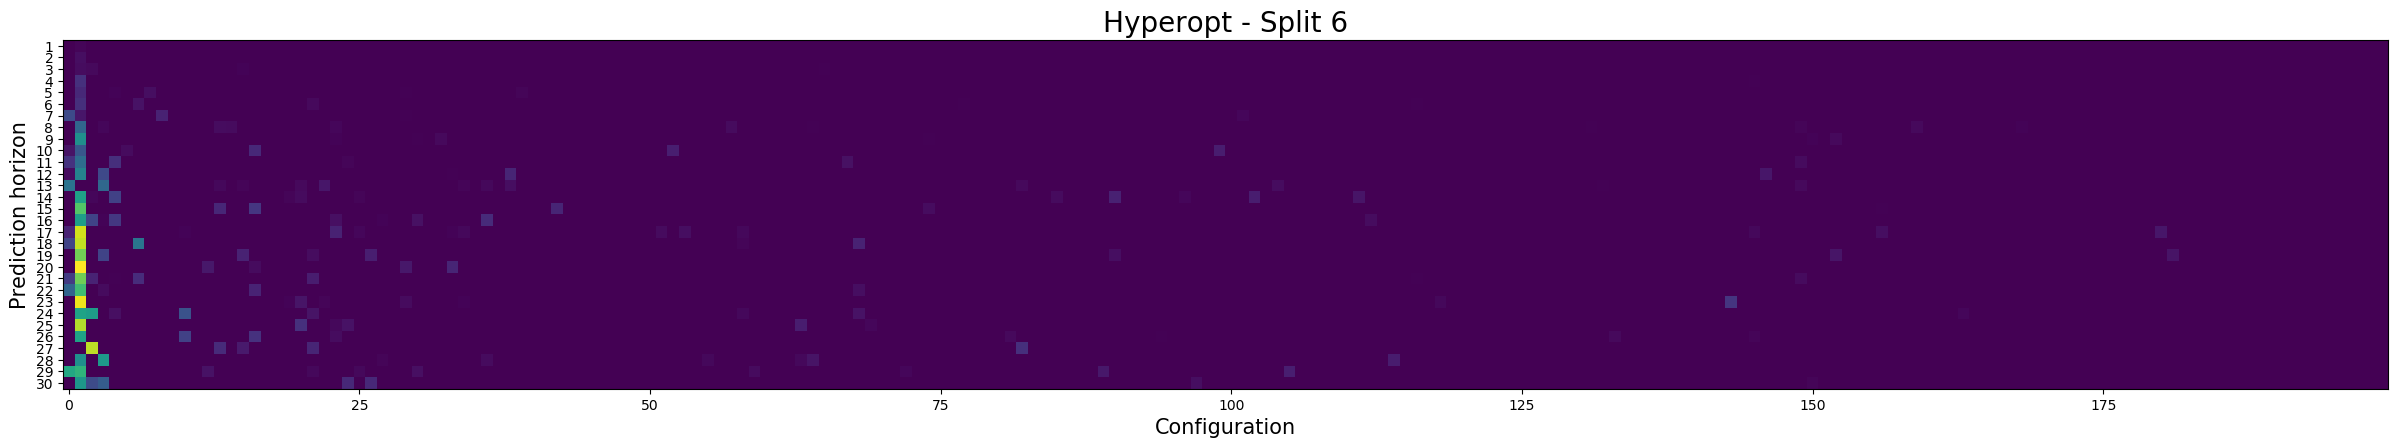

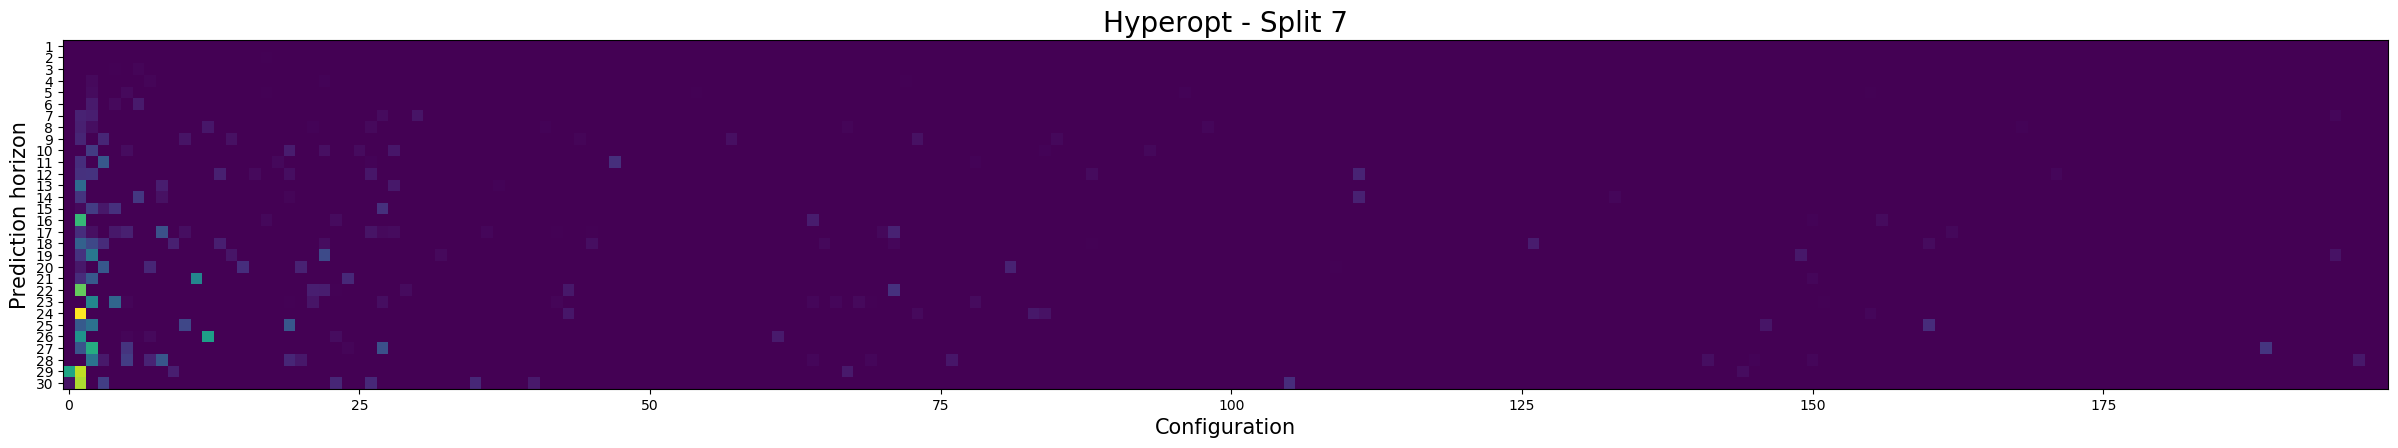

In [22]:
for split_number in hyper_params_recursive.index.get_level_values(0).unique():
    hyper_params_recursive_1 = hyper_params_recursive.loc[split_number]
    hyper_params_recursive_1 = pd.DataFrame(hyper_params_recursive_1.tolist())
    hyper_params_recursive_1 = hyper_params_recursive_1.iloc[:,:200]
    
    with plt.style.context("default"):
        fig, ax = plt.subplots(figsize = (30, 18))
        im = ax.imshow(hyper_params_recursive_1.astype(float), cmap = "viridis")

        ax.set_yticks(hyper_params_recursive_1.index)
        ax.grid(False)
        ax.set_yticklabels(hyper_params_recursive_1.index + 1)
        ax.set_xlabel("Configuration", fontsize = 15)
        ax.set_ylabel("Prediction horizon", fontsize = 15)
        ax.set_title("Hyperopt - Split %d" % split_number, fontsize = 20)
        for i in range(hyper_params_recursive_1.shape[0]):
            ax.axhline(i + 0.5, color = "white", lw = 0.0)
        
        # Save the figure.
        fig.savefig(dir_results_hyperparameter_tuning + "/recursive_split_%s.png" % split_number, bbox_inches = "tight", dpi = 300)

## Forecasting

In [23]:
QUANTILES = False
ALPHA_QUANTILES = 0.75
SMOOTH_PREDICTION = True

In [24]:
# Open the names of the parameters of the model.
with open(dir_hyper_params + "space1", "rb") as fp:
    parameter_names_model = pickle.load(fp)

In [25]:
# Open the names of the parameters of the features.
with open(dir_hyper_params + "space2", "rb") as fp:
    parameter_names_indicator = pickle.load(fp)

In [26]:
# Load the lags dictionary.
with open (dir_hyper_params + "lags_dict", "rb") as fp:
    lags_dict = pickle.load(fp)

In [27]:
def take_lags(x, lags = None, delay = False):
    if lags is not None:
        lags = [(x, "x(t)") if i == 1 else (x, "x(t-%d)" % (i-1)) for i in lags]
        if delay:
            lags.append((x, "delay"))
    else:
        lags = [(x, slice(None))]
    return lags

In [28]:
# Define the splits to consider to compute the corresponding prediction based on hyperparameters tuning.
SPLITS_TO_USE = best_result.index.get_level_values(0).unique()

In [29]:
def model(train, test, lags_dict, out, target, quantiles = False, hyper = False):
    """
    This function allows to predict 'out' steps ahead in the future of the 'target' variable of each site in the
    'train' group. The predictions of 'out' steps in the future start from the last date of the 'train' group 
    provided.
    
    """
    # Use the best parameters obtained through a previous hyperparameter tuning.
    if hyper:
        # Define the best parameters for the current split obtained by the hyperparameter tuning.
        parameter_names = parameter_names_model + parameter_names_indicator
        best_parameters = best_result.loc[split_number][parameter_names].astype(float)
        # Model parameters.
        best_parameter_indicator = best_parameters[parameter_names_indicator]
        # Indicators parameters.
        best_parameter_model = best_parameters[parameter_names_model]

    #####################
    ### DATA CREATION ###
    #####################
    
    print("Load data...")

    # Define the first level of multi-sites (countries level).
    countries = train.columns.get_level_values(0).unique()

    # Creation of an unique pot for putting the training points (X, y) for all the multi-sites (countries and provinces) for each prediction horizon.
    training_points = {"X": {h+1: [] for h in range(out)}, 
                       "y": {h+1: [] for h in range(out)}}
    # Creation of the input test points specifically for each site (country and province) and prediction horizon.
    test_input_points = {country: {province: {h+1: None for h in range(out)} for province in train[country].columns.get_level_values(0).unique()} for country in countries}

    for country in countries:
        # Select the subdataframe corresponding to the current country.
        train_country = train[country]
        # Define the second level of multi-sites (provinces level).
        provinces = train_country.columns.get_level_values(0).unique()
        for province in provinces:
            for h in range(out):
                # Training samples.
                X_train = pd.read_csv(dir_data + "/train/%s/%s/X_train_split%d_h%d.csv" % (country, province, split_number, h+1), header = [0, 1], index_col = 0) 
                y_train = pd.read_csv(dir_data + "/train/%s/%s/y_train_split%d_h%d.csv" % (country, province, split_number, h+1), header = [0, 1], index_col = 0) 
                X_test = pd.read_csv(dir_data + "/test/%s/%s/X_test_split%d_h%d.csv" % (country, province, split_number, h+1), header = [0, 1], index_col = 0) 

                # Get the features to keep for the current prediction horizon according to the hyperparameter tuning.
                if hyper:
                    # Select features.
                    # Decide the indicators to keep based on values (0 or 1).
                    space_features = {k: v for k,v in dict(best_parameter_indicator.loc[h+1]).items() if v == 1}
                    # Select the corresponding lags.
                    space_features = {feature: lags_dict[feature] for feature in space_features.keys()}
                    # Flatten list.
                    features = list(itertools.chain(*list(space_features.values())))
                    # Keep features.
                    X_train = pd.concat([X_train.loc[:, feature] for feature in features], axis = 1).sort_index(axis = 1)
                    X_test = pd.concat([X_test.loc[:, feature] for feature in features], axis = 1).sort_index(axis = 1)

                # Store information.
                training_points["X"][h+1].append(X_train)
                training_points["y"][h+1].append(y_train)
                test_input_points[country][province][h+1] = X_test

    # Concatenate training data for each prediction horizon in order to consider them into an unique pot.
    for h in range(out):
        training_points["X"][h+1] = pd.concat(training_points["X"][h+1]).reset_index(drop = True) 
        training_points["y"][h+1] = pd.concat(training_points["y"][h+1]).reset_index(drop = True) 
        
    print("Complete!")
        
    ###################
    ### FORECASTING ###
    ###################
    
    print("Forecasting...")

    # Create the dataframe where to store the predictions of the target.
    c1 = pd.MultiIndex.from_tuples(map(lambda x: (x[0], x[1], "lower_quantile"), train.columns.droplevel(2)), names = ["Country", "AdminStrata", "Target"])
    c2 = pd.MultiIndex.from_tuples(map(lambda x: (x[0], x[1], "Forecast"), train.columns.droplevel(2)), names = ["Country", "AdminStrata", "Target"])
    c3 = pd.MultiIndex.from_tuples(map(lambda x: (x[0], x[1], "upper_quantile"), train.columns.droplevel(2)), names = ["Country", "AdminStrata", "Target"])
    predictions = pd.DataFrame(index = test.index, columns = c1.union(c2).union(c3))   

    # Training model.
    models = {h+1: None for h in range(out)}
    r2_train = {h+1: None for h in range(out)}
    r2_test = {country: {h+1: None for h in range(out)} for country in countries}
    for h in range(out):
        # Train the model for the current prediction horizon.
        X_train, y_train = training_points["X"][h+1], training_points["y"][h+1]
        
        # Get the best model parameters for the current prediction horizon if exist the information about.
        if hyper:
            # Select best model parameters.
            best_parameter_model_h = dict(best_parameter_model.loc[h+1])
            # Convert to int type the float numbers that are integers.
            best_parameter_model_h = {k: int(v) if v.is_integer() else v for k,v in best_parameter_model_h.items()}

        # Model.
        if quantiles:
            # Train model.
            model = GradientBoostingRegressor(**best_parameter_model_h)
            model.set_params(loss = "ls")
            model.fit(X_train, y_train.flatten())
            # Lower model.
            model_lower = GradientBoostingRegressor(**best_parameter_model_h)
            model_lower.set_params(loss = "quantile", alpha = 1.-ALPHA_QUANTILES)
            model_lower.fit(X_train, y_train.flatten())
            # Upper model.
            model_upper = GradientBoostingRegressor(**best_parameter_model_h)
            model_upper.set_params(loss = "quantile", alpha = ALPHA_QUANTILES)
            model_upper.fit(X_train, y_train.flatten())
        else:  
            if hyper:
                model = xgb.XGBRegressor(**best_parameter_model_h, objective = "reg:squarederror")
            else:
                model = xgb.XGBRegressor(n_estimators = 100, objective = "reg:squarederror")
            # Train model.
            model.fit(X_train, y_train)
            # Lower model.
            model_lower = None
            # Upper model.
            model_upper = None
        
        # Save models.
        models[h+1] = (model, model_lower, model_upper, X_train.columns)
        # Save training r2 scores.
        r2_train[h+1] = model.score(X_train, y_train)
       
        # Forecasting.
        for country in countries:
            X_test_list, y_test_list = list(), list()
            # Define the second level multi-sites (provinces).
            provinces = train[country].columns.get_level_values(0).unique()
            for province in provinces:
                X_test = test_input_points[country][province][h+1]
                y_hats = model.predict(X_test)[0]
                
                # Save the true information about this test point.
                X_test_list.append(X_test)
                y_true = test[(country, province, target)].loc[predictions.index[h]] 
                y_test_list.append([y_true])

                # Store the predicted values into the dataframe.
                predictions[(country, province, "Forecast")].loc[predictions.index[h]] = y_hats

                # Prediction for the quantiles.
                if quantiles:
                    y_hats_lower = model_lower.predict(X_test)[0]
                    predictions[(country, province, "lower_quantile")].loc[predictions.index[h]] = y_hats_lower
                    y_hats_upper = model_upper.predict(X_test)[0]
                    predictions[(country, province, "upper_quantile")].loc[predictions.index[h]] = y_hats_upper

            # Compute the r2 test for the current prediction horizon and country.
            r2_test_country = model.score(pd.concat(X_test_list).reset_index(drop = True), np.expand_dims(np.concatenate(y_test_list), 1))
            r2_test[country][h+1] = r2_test_country  
 
    # Define the shape of the training and test points.    
    shape_training_points = training_points.copy()
    shape_test_points = test_input_points.copy()
    for h in range(out):
        shape_training_points["X"][h+1] = shape_training_points["X"][h+1].shape
        shape_training_points["y"][h+1] = shape_training_points["y"][h+1].shape
        for country in countries:
            provinces = train[country].columns.get_level_values(0).unique()
            for province in provinces:
                shape_test_points[country][province][h+1] = shape_test_points[country][province][h+1].shape
                
    print("Complete!")

    return predictions, models, r2_train, r2_test, shape_training_points, shape_test_points

In [30]:
# Create a dictionary to store forecasting information for each split.
information_to_store = {"shape_train": None, # Save the shape of the training points.
                        "shape_test": None, # Save the shape of the test points.
                        "r2_train": None, # Save the r2 on the training points.
                        "r2_test": None, # Save the r2 on the test points.
                        "models": None, # Save the trained models (one for each prediction horizon) with the corresponding feature names.
                        "prediction_sites": None, # Save the predictions for each site (province).
                        "loss_sites": None, # Save the prediction loss (mse) for each site (province).
                        "loss_overall": None, # Save the overall loss. 
                        "loss_h": None} # Save the loss as function of the prediction horizon among all the sites (province).

TOTAL_RESULTS = {split_number: information_to_store.copy() for split_number in SPLITS_TO_USE}

# Forecasting.
for split_number, (train, test) in SPLITS.items():
    if split_number in SPLITS_TO_USE:
        print("SPLIT %d/%d" % (split_number, len(SPLITS.keys())))

        ## ACTUAL ##
        # Define the test points of the target to predict for each site (country and province).
        true = test.xs(TARGET, axis = 1, level = 2, drop_level = False)
        # Define the number of days to predict.
        test_size = len(true)
        print("Range of days to predict: %s - %s" % (str(true.index[0].date()), str(true.index[-1].date())))

        ## NAIVE ##
        # Define the predictions for the Naive model.
        naive = train.xs(TARGET, axis = 1, level = 2, drop_level = False).iloc[-1].to_frame().transpose()
        naive = naive.loc[naive.index.repeat(test_size)]
        naive = naive.rename(columns = {"FCS": "Naive"})
        naive.index = true.index

        ## MODEL ##
        # Train the model to predict the test_size points for each site (country and province).
        predictions, models, r2_train, r2_test, shape_train, shape_test = model(train, test, lags_dict, TEST_SIZE, TARGET, 
                                                                                quantiles = QUANTILES, hyper = True)

        # Smooth the output prediction over the prediction horizons.
        if SMOOTH_PREDICTION:
            def smooth_output(serie):
                if serie.isna().sum() > 0:
                    return serie
                else:
                    # Smooth serie.
                    smooth_serie = savgol_filter(serie, 15, 3)
                    return smooth_serie
            predictions = predictions.apply(smooth_output)

        ## ALL ##
        results = pd.concat([true, predictions, naive], axis = 1).sort_index(axis = 1, level = 0)
        
        # Analysis of the forecast results.  
        # Define the total prediction loss for each site (province) not considering quantiles.
        select = results.columns.get_level_values(2).isin(["Forecast", TARGET, "Naive"])
        results_no_quantiles = results.loc[:, select]

        def f_loss(x, level):
            # Model.
            model = mse(x.xs(TARGET, axis = 1, level = level), x.xs("Forecast", axis = 1, level = level))
            # Naive.
            naive = mse(x.xs(TARGET, axis = 1, level = level), x.xs("Naive", axis = 1, level = level))  
            return pd.Series([model, naive], index = ["Model", "Naive"])

        loss_sites = results_no_quantiles.groupby(axis = 1, level = [0, 1]).apply(lambda x: f_loss(x, 2)).transpose()

        # Define the overall loss.
        loss = loss_sites.groupby(axis = 0, level = 0).mean().mean()
        print("Overall loss:")
        print(loss)
        print("Country loss:")
        print(loss_sites.groupby(axis = 0, level = 0).mean())

        # Compute the loss as a function of the prediction horizon among all the sites (provinces).
        loss_h = results_no_quantiles.transpose().unstack(2).groupby(axis = 0, level = 0).apply(lambda x: x.groupby(axis = 1, level = 0).apply(lambda x: f_loss(x, 1)).transpose())

        # Save the results for the current split.
        TOTAL_RESULTS[split_number]["r2_train"] = r2_train 
        TOTAL_RESULTS[split_number]["r2_test"] = r2_test  
        TOTAL_RESULTS[split_number]["shape_train"] = shape_train 
        TOTAL_RESULTS[split_number]["shape_test"] = shape_test 
        TOTAL_RESULTS[split_number]["models"] = models 
        TOTAL_RESULTS[split_number]["prediction_sites"] = results
        TOTAL_RESULTS[split_number]["loss_sites"] = loss_sites
        TOTAL_RESULTS[split_number]["loss_overall"] = loss
        TOTAL_RESULTS[split_number]["loss_h"] = loss_h

SPLIT 1/7
Range of days to predict: 2020-02-01 - 2020-03-01
Load data...
Complete!
Forecasting...
Complete!
Overall loss:
Model    20.801938
Naive    18.659239
dtype: float64
Country loss:
             Model      Naive
Country                      
Yemen    20.801938  18.659239
SPLIT 2/7
Range of days to predict: 2020-03-01 - 2020-03-30
Load data...
Complete!
Forecasting...
Complete!
Overall loss:
Model    14.879419
Naive    20.491677
dtype: float64
Country loss:
             Model      Naive
Country                      
Yemen    14.879419  20.491677
SPLIT 3/7
Range of days to predict: 2020-04-01 - 2020-04-30
Load data...
Complete!
Forecasting...
Complete!
Overall loss:
Model    15.677328
Naive    13.632796
dtype: float64
Country loss:
             Model      Naive
Country                      
Yemen    15.677328  13.632796
SPLIT 4/7
Range of days to predict: 2020-05-01 - 2020-05-30
Load data...
Complete!
Forecasting...
Complete!
Overall loss:
Model    11.886012
Naive    48.952700
dty

## Results analysis

### Overall result

In [31]:
total_loss = list()
for split_number in SPLITS_TO_USE:
    loss = TOTAL_RESULTS[split_number]["loss_overall"]
    total_loss.append(loss)

In [32]:
print("Overall loss (mse):")
pd.concat(total_loss, axis = 1).mean(axis = 1)

Overall loss (mse):


Model    18.420997
Naive    24.031948
dtype: float64

In [33]:
total_loss_country = list()
for split_number in SPLITS_TO_USE:
    loss = TOTAL_RESULTS[split_number]["loss_sites"].groupby(axis = 0, level = 0).mean()
    total_loss_country.append(loss)

In [34]:
print("Overall loss (mse):")
pd.concat(total_loss_country, axis = 1).groupby(axis = 1, level = 0).mean()

Overall loss (mse):


,Model,Naive
Country,,
Yemen,18.420997,24.031948


### Total prediction loss for the sites among the various splits

In [35]:
def full_extent(ax, pad = 0.0):
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    bbox = Bbox.union([item.get_window_extent() for item in items])
    return bbox.expanded(1.0 + pad, 1.0 + pad)

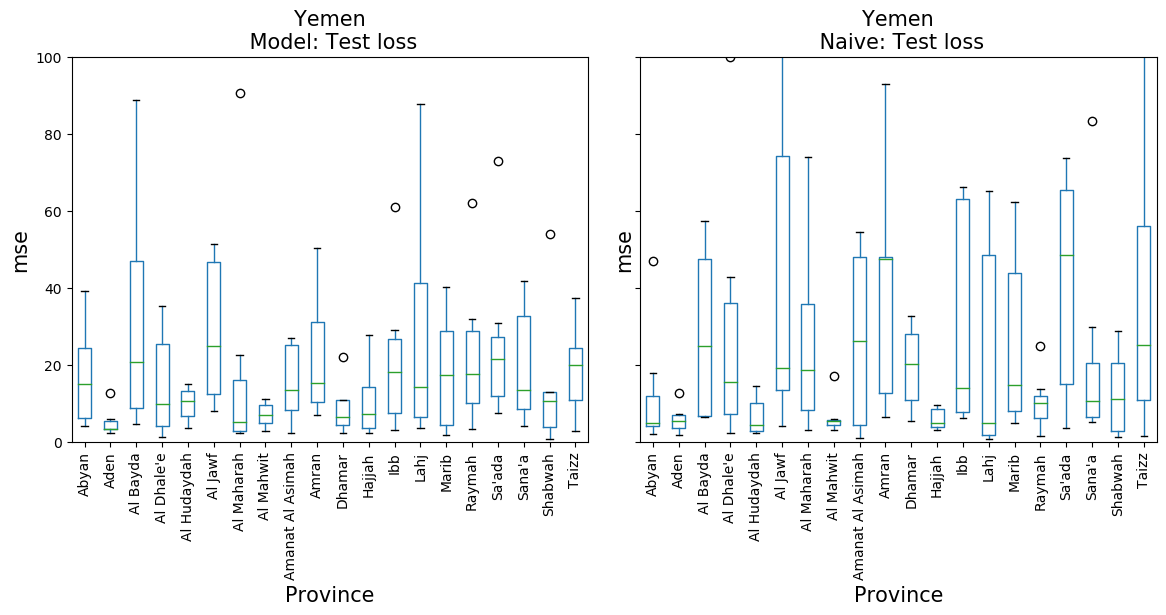

In [36]:
with plt.style.context("default"):
    # Define the number of figures on x axis.
    cols = 2
    # Define the number of figures on y axis.
    rows = len(COUNTRIES_TO_CONSIDER)
    # Define the subplot figure.
    fig, axs = plt.subplots(len(COUNTRIES_TO_CONSIDER),2, sharey = True, figsize = (7*cols, 5*rows), squeeze = False)
    fig.subplots_adjust(wspace = 0.1, hspace = 0.8)
    for j,country in enumerate(COUNTRIES_TO_CONSIDER):
        value = pd.DataFrame()
        for split_number in SPLITS_TO_USE:
            loss_sites = TOTAL_RESULTS[split_number]["loss_sites"].loc[country]
            value = pd.concat([value, loss_sites], axis = 1, sort = True)
        for i,m in enumerate(value.columns.get_level_values(0).unique()):
            # Create box-plot.
            value[[m]].transpose().reset_index(drop = True).boxplot(rot = 90, ax = axs[j,i])
            # Set attributes box-plot.
            axs[j,i].set_title(country + "\n %s: Test loss" % m, fontsize = 15)
            axs[j,i].set_xlabel("Province", fontsize = 15)
            axs[j,i].set_ylabel("mse", fontsize = 15)
            axs[j,i].set_ylim([0, 100])
            axs[j,i].grid(b = None)
            
            # Save just the portion of the current axes.
            extent = full_extent(axs[j,i]).transformed(fig.dpi_scale_trans.inverted())
            extent = axs[j,i].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
            fig.savefig(dir_output_test + "/Sites_%s_%s.png" % (country, m), bbox_inches = extent, dpi = 300)

### Loss of each split as function of the prediction horizon

In [39]:
colors = {"Naive": "red", "Model": "blue"}

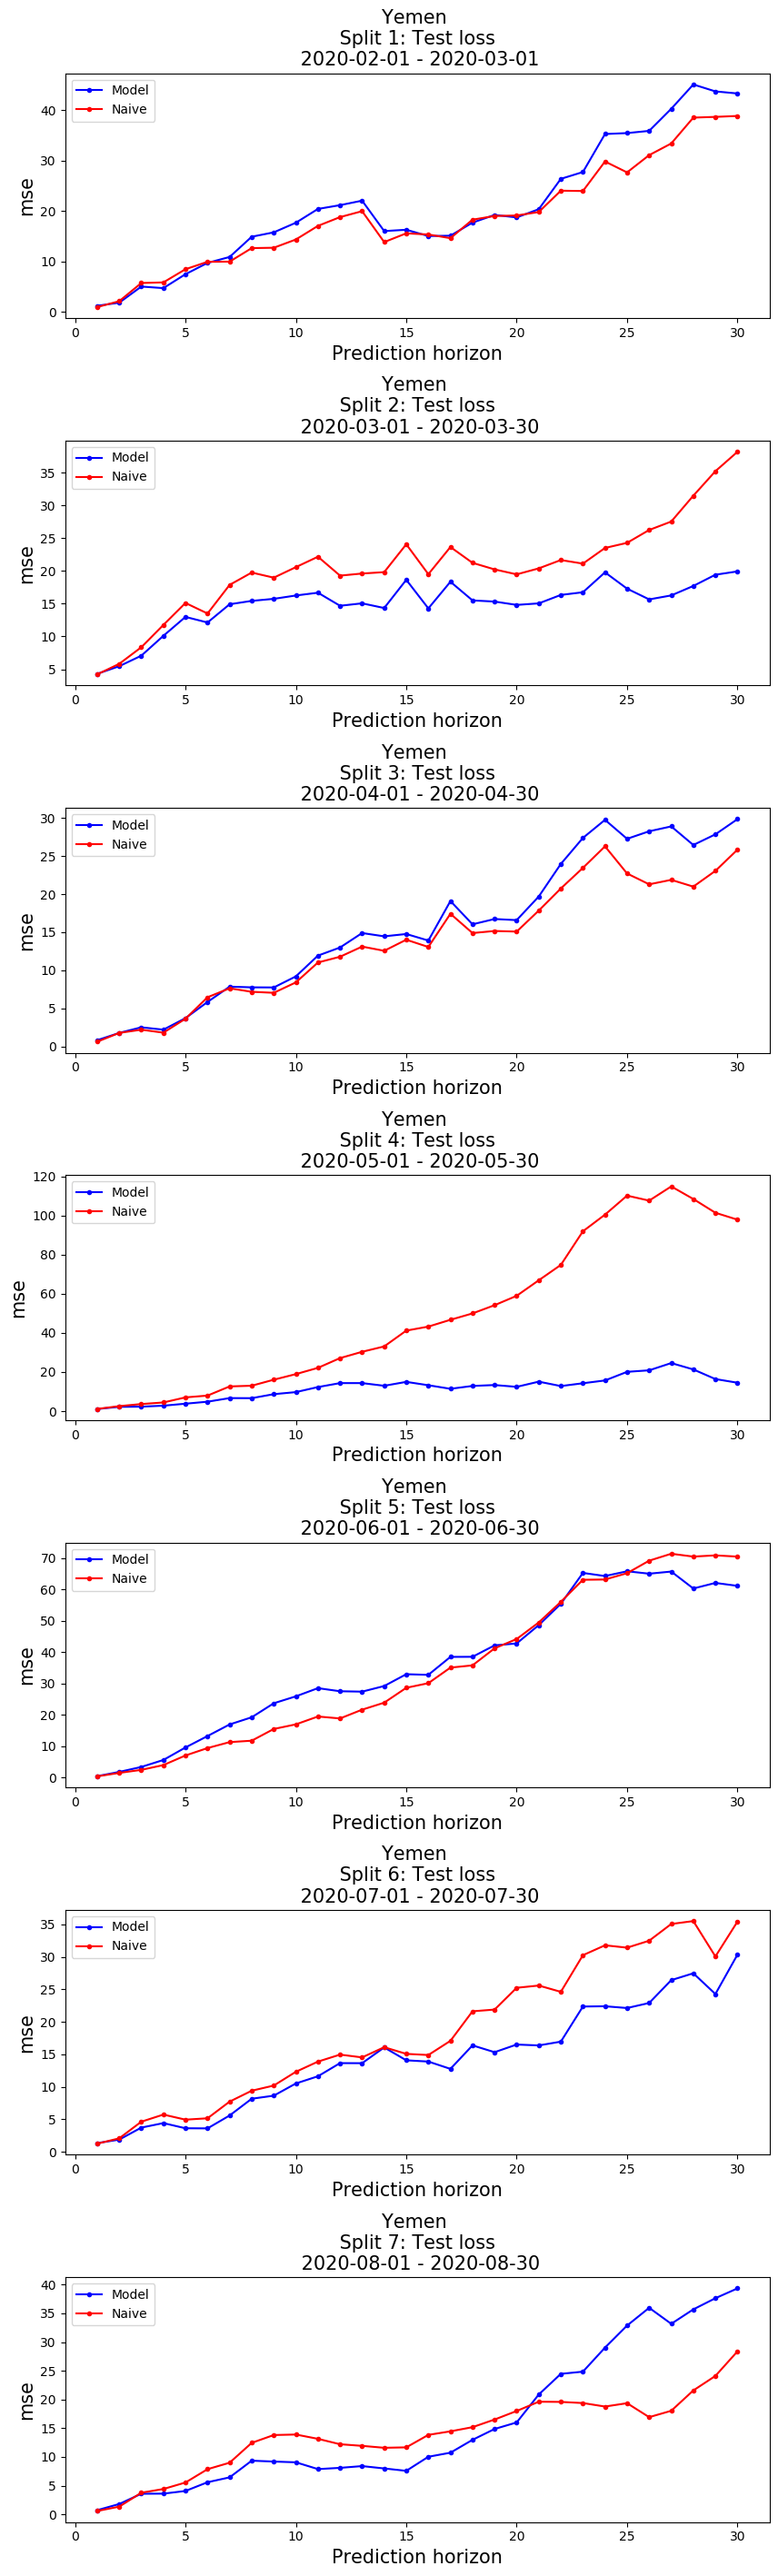

In [38]:
with plt.style.context("default"):
    # Define the number of figures on x axis.
    cols = len(COUNTRIES_TO_CONSIDER)
    # Define the number of figures on y axis.
    rows = len(SPLITS_TO_USE)
    # Define the subplot figure.
    fig, axs = plt.subplots(rows, cols, figsize = (10*cols, 5*rows), squeeze = False)
    fig.subplots_adjust(wspace = 0.05, hspace = 0.5)
    for j,country in enumerate(COUNTRIES_TO_CONSIDER):
        value = pd.DataFrame()
        for i,split_number in enumerate(SPLITS_TO_USE):      
            loss_sites = TOTAL_RESULTS[split_number]["loss_h"].loc[country].reset_index(drop = True)
            for k,m in enumerate(loss_sites.columns.get_level_values(0).unique()):  
                value_statistic = loss_sites[[m]]
                value_statistic.index = loss_sites.index + 1
                
                # Get the start and the end dates of the test set of the current split.
                start, end = str(SPLITS[split_number][1].index[0].date()), str(SPLITS[split_number][1].index[-1].date())
                
                # Plot.
                value_statistic[m].plot(style = ".-", label = m, ax = axs[i,j], c = colors[m])
                # Set attributes of the plot.
                axs[i,j].set_title("%s \n Split %d: Test loss \n %s - %s" % (country, split_number, start, end), fontsize = 15)
                axs[i,j].legend(loc = "best")
                axs[i,j].set_xlabel("Prediction horizon", fontsize = 15)
                axs[i,j].set_ylabel("mse", fontsize = 15)
                
                # Save just the portion of the current axes.
                extent = full_extent(axs[i,j]).transformed(fig.dpi_scale_trans.inverted())
                extent = axs[i,j].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
                fig.savefig(dir_output_test + "/Loss_split_%d_%s.png" % (split_number, country), bbox_inches = extent, dpi = 300)

### Total loss as function of the prediction horizon

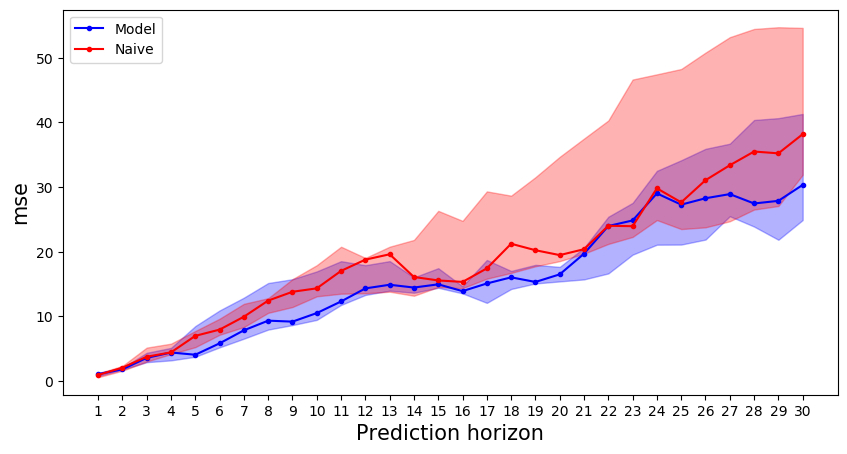

In [41]:
with plt.style.context("default"):
    for j,country in enumerate(COUNTRIES_TO_CONSIDER):
        fig, axs = plt.subplots(figsize = (10, 5))
        value = pd.DataFrame()
        for split_number in SPLITS_TO_USE:      
            loss_sites = TOTAL_RESULTS[split_number]["loss_h"].loc[country].reset_index(drop = True)
            value = pd.concat([value, loss_sites], axis = 1, sort = True)           
        for i, m in enumerate(value.columns.get_level_values(0).unique()):    
            value_statistic = value[[m]].agg([lambda x: x.quantile(0.25), np.median, lambda x: x.quantile(0.75)], axis = 1)
            value_statistic.columns = ["lower_quantile", "mean", "upper_quantile"]
            value_statistic.index = value_statistic.index + 1

            # Plot.
            value_statistic["mean"].plot(style = ".-", label = m, ax = axs, c = colors[m])
            axs.fill_between(x = value_statistic["mean"].index, y1 = value_statistic["lower_quantile"], 
                             y2 = value_statistic["upper_quantile"], color = colors[m], alpha = 0.3)
            # Set attributes of the plot.
            #axs[j,0].set_title("%s \n Test loss" % country, fontsize = 15)
            axs.legend(loc = "upper left")
            axs.set_xlabel("Prediction horizon", fontsize = 15)
            axs.set_ylabel("mse", fontsize = 15)
            axs.set_xticks(np.arange(1, 31))

            fig.savefig(dir_output_test + "/Loss_%s.png" % (country), bbox_inches = "tight", dpi = 300)

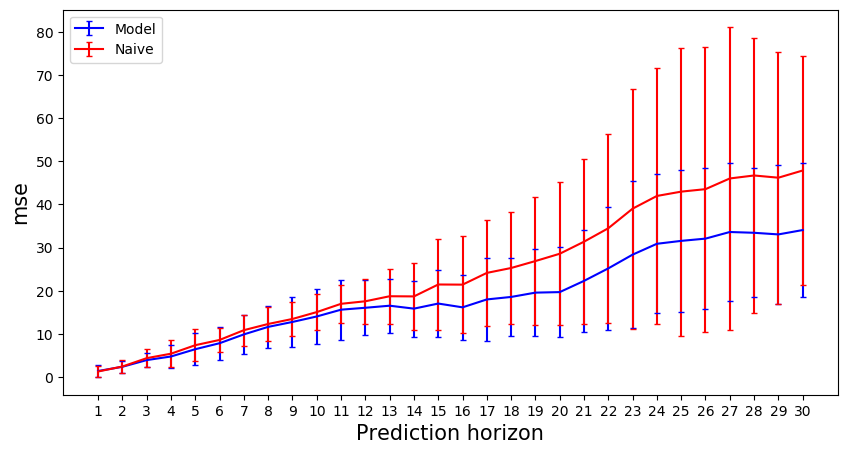

In [193]:
with plt.style.context("default"):
    # Define the number of figures on x axis.
    cols = 1
    # Define the number of figures on y axis.
    rows = len(COUNTRIES_TO_CONSIDER)
    # Define the subplot figure.
    fig, axs = plt.subplots(rows, cols, figsize = (10*cols, 5*rows), squeeze = False)
    fig.subplots_adjust(wspace = 0.02, hspace = 0.5)
    for j,country in enumerate(COUNTRIES_TO_CONSIDER):
        value = pd.DataFrame()
        for split_number in SPLITS_TO_USE:      
            loss_sites = TOTAL_RESULTS[split_number]["loss_h"].loc[country].reset_index(drop = True)
            value = pd.concat([value, loss_sites], axis = 1, sort = True)           
        for i, m in enumerate(value.columns.get_level_values(0).unique()):    
            value_statistic = value[[m]].agg([np.mean, np.std], axis = 1)
            value_statistic.columns = ["mean", "std"]
            value_statistic.index = value_statistic.index + 1
            
            # Plot.
            value_statistic["mean"].plot(style = ".-", ms = 6, yerr = value_statistic["std"], capsize = 2, label = m, ax = axs[j,0], c = colors[m])
            # Set attributes of the plot.
            #axs[j,0].set_title("%s \n Test loss" % country, fontsize = 15)
            axs[j,0].legend(loc = "best")
            axs[j,0].set_xlabel("Prediction horizon", fontsize = 15)
            axs[j,0].set_ylabel("mse", fontsize = 15)
            axs[j,0].set_xticks(np.arange(1, 31))
            
            # Save just the portion of the current axes.
            extent = full_extent(axs[j,0]).transformed(fig.dpi_scale_trans.inverted())
            extent = axs[j,0].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
            fig.savefig(dir_output_test + "/mean_Loss_%s.png" % (country), bbox_inches = "tight", dpi = 300)

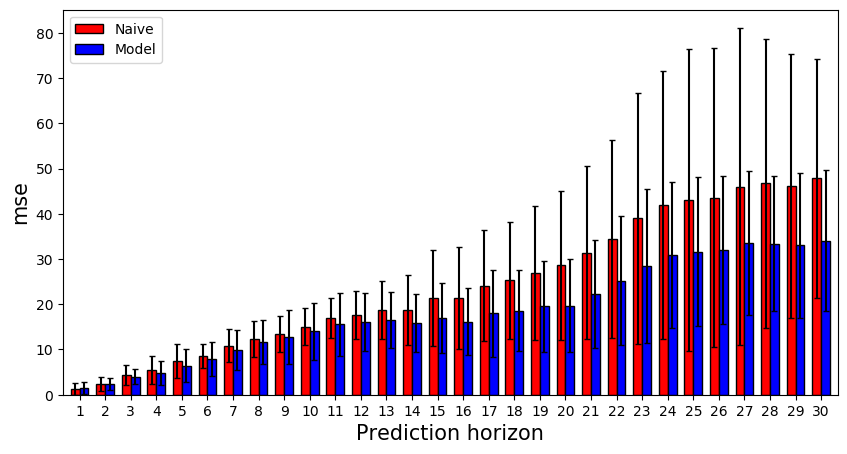

In [183]:
with plt.style.context("default"):
    for j,country in enumerate(COUNTRIES_TO_CONSIDER):
        fig, axs = plt.subplots(figsize = (10, 5))
        all_value = list()
        value = pd.DataFrame()
        for split_number in SPLITS_TO_USE:      
            loss_sites = TOTAL_RESULTS[split_number]["loss_h"].loc[country].reset_index(drop = True)
            value = pd.concat([value, loss_sites], axis = 1, sort = True)           
        for i, m in enumerate(value.columns.get_level_values(0).unique()):    
            value_statistic = value[[m]].agg([np.std, np.mean], axis = 1)
            value_statistic.columns = ["std_%s" % m, "%s" % m]
            value_statistic.index = value_statistic.index + 1
            all_value.append(value_statistic)
        
        all_value = pd.concat(all_value, axis = 1)
        
        w = 0.9
        s = 0.8
        
        indx = list()
        for i,index in enumerate(all_value.index):
            if i == 0:
                indx.append(index)
            else:
                indx.append(indx[i-1] + 2*w + s)

        axs.bar(np.array(indx) - w/2, all_value["Naive"].values, yerr = all_value["std_Naive"].values.T, 
                width = w, color = colors["Naive"], label = "Naive", align = "center", edgecolor = "black", 
                capsize = 2, ecolor = "black", alpha = 1.)
        axs.bar(np.array(indx) + w/2, all_value["Model"].values, yerr = all_value["std_Model"].values.T, 
                width = w, color = colors["Model"], label = "Model", align = "center", edgecolor = "black", 
                capsize = 2, ecolor = "black", alpha = 1.)
        # Set attributes of the plot.
        #axs[j,0].set_title("%s \n Test loss" % country, fontsize = 15)
        axs.legend(loc = "upper left")
        axs.set_xlabel("Prediction horizon", fontsize = 15)
        axs.set_ylabel("mse", fontsize = 15)
        axs.tick_params(axis = "x", labelrotation = 0)
        axs.set_xticks(np.array(indx))
        axs.set_xticklabels(np.arange(1, 31))  
        axs.set_ylim(0)
        axs.set_xlim((indx[0]-w-s, indx[-1]+w+s))

        fig.savefig(dir_output_test + "/Loss_bar_%s.png" % (country), bbox_inches = "tight", dpi = 300)

### Predictions

In [184]:
def plot_predictions(name1, name2, results):
     # Select the subdataframe.
    if name1 != None and name2 != None:
        group = results[name1]["prediction_sites"][name2]

        def add_entire_target(group):
            province = group.name
            select = group.columns.get_level_values(1).isin(["Forecast", "lower_quantile", "upper_quantile"])
            group = group.loc[:, select]
            actual = df[name2].xs(TARGET, axis = 1, level = 1, drop_level = False)[(province, "FCS")].to_frame()

            return pd.concat([group, actual], axis = 1)

        group = group.groupby(axis = 1, level = 0, group_keys = False).apply(add_entire_target)
        group = group.rename(columns = {"FCS": "original", "Forecast": "forecast"}, level = 1)
        
        # Get the start and the end dates of the test set.
        start, end = str(SPLITS[name1][1].index[0].date()), str(SPLITS[name1][1].index[-1].date())

        with plt.style.context("default"):
            # Plot prediction.
            TsIP(group[:end]).interactive_plot_predictions(quantiles = False, title = "%s - %s" % (start, end), matplotlib = True, 
                                                           yaxis = "% of people with poor and borderline FCS", style = "lines", 
                                                           first_last_valid_index_group = True, save_path = dir_output_test + "/prediction.png")                  
    else:
        pass

# Create figure.
w1 = widgets.Dropdown(options = TOTAL_RESULTS.keys(), description = "Split", disabled = False, value = None)
w2 = widgets.Dropdown(options = COUNTRIES_TO_CONSIDER, description = "Country", disabled = False, value = None)

hbox = widgets.HBox([w1, w2])
out = widgets.interactive_output(plot_predictions, {"name1": w1, "name2": w2, "results": fixed(TOTAL_RESULTS)})
display(hbox, out)     

Output()

### r2 scores

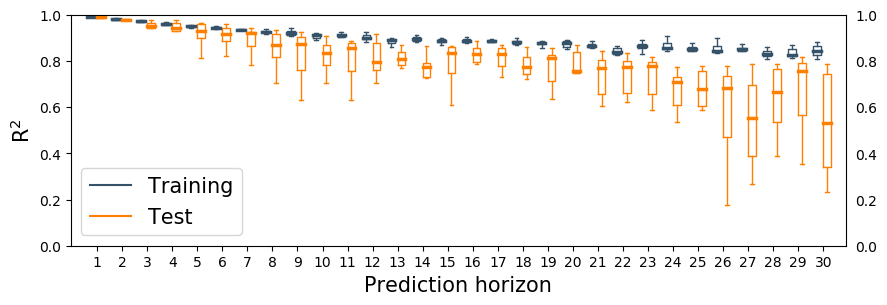

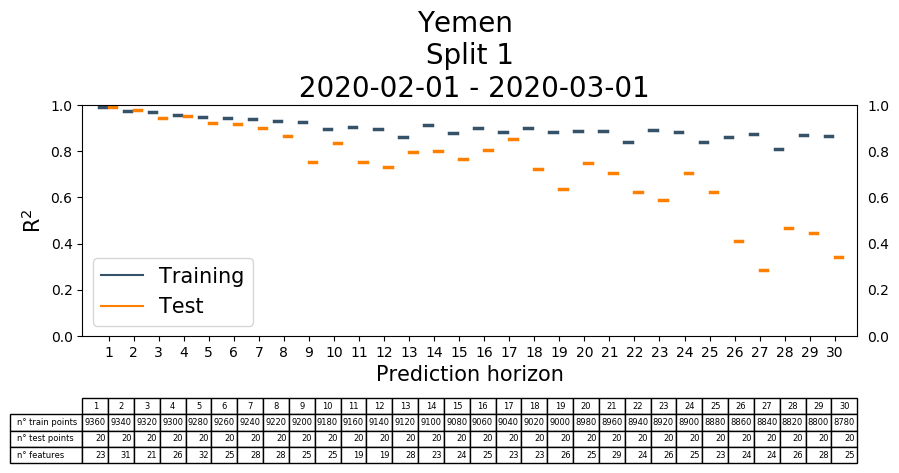

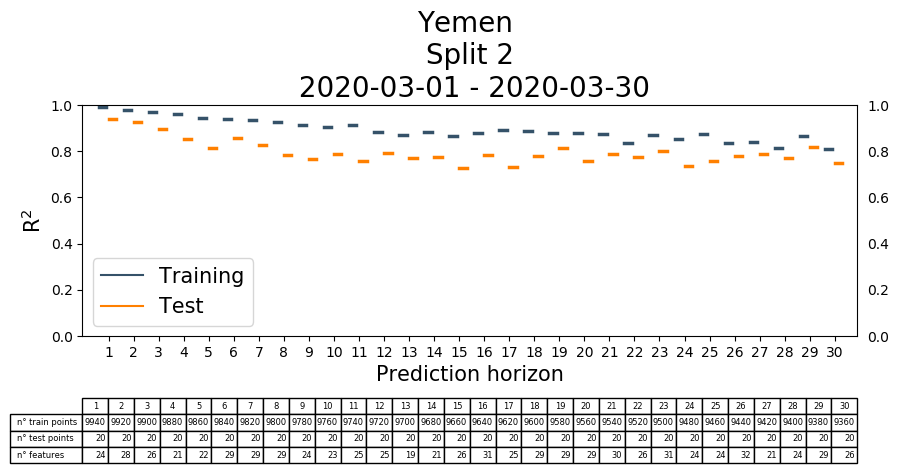

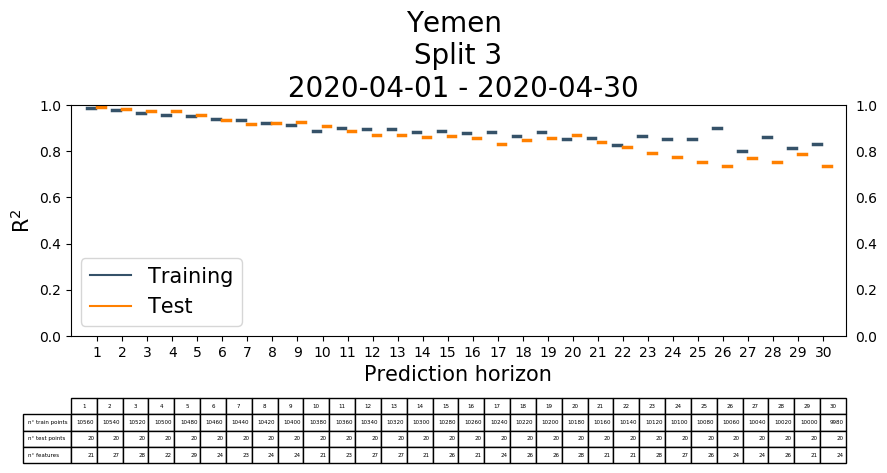

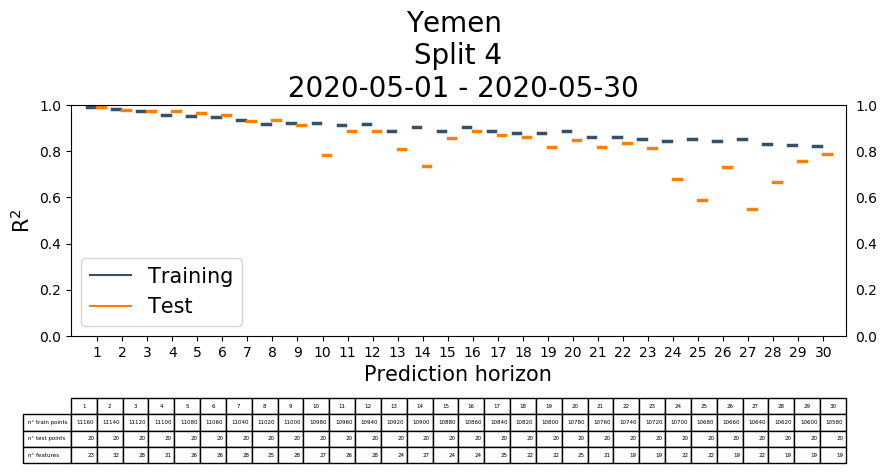

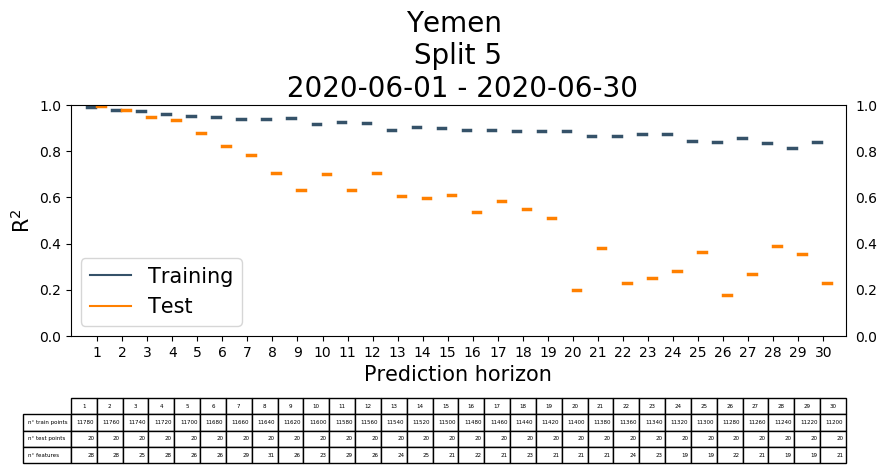

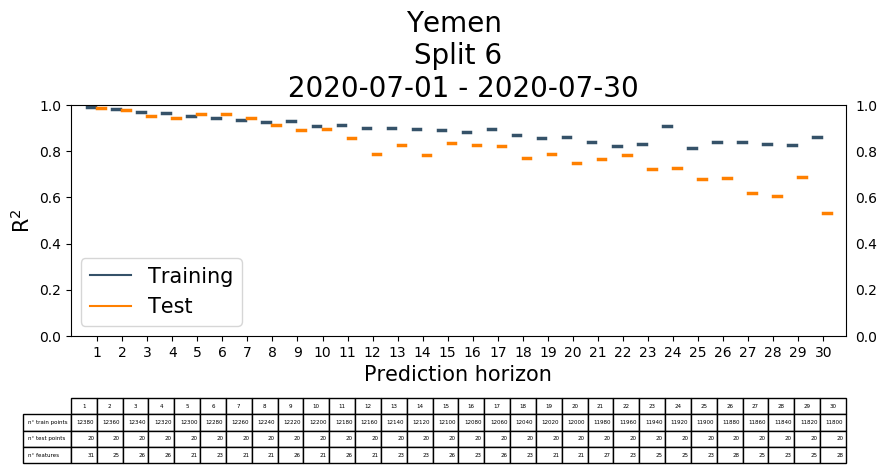

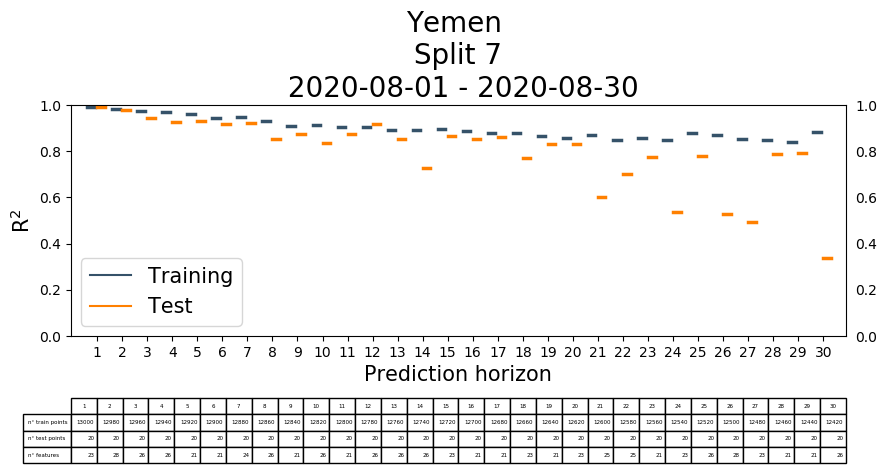

In [185]:
with plt.style.context("default"):
    for j,country in enumerate(COUNTRIES_TO_CONSIDER):
        # Get the information of the r2 train for each prediction horizon considering the split information together.
        data_train = pd.DataFrame({split_number: TOTAL_RESULTS[split_number]["r2_train"].values() for split_number in TOTAL_RESULTS.keys()})
        data_train.index = data_train.index + 1
        # Get the information of the r2 test for each prediction horizon considering the split information together.
        data_test = pd.DataFrame({split_number: TOTAL_RESULTS[split_number]["r2_test"][country].values() for split_number in TOTAL_RESULTS.keys()})
        data_test.index = data_test.index + 1
        
        # Plot the box-plot.
        fig, axs = plt.subplots(figsize = (10, 3))
        plot_r2_box_plot(data_train.values.T, data_test.values.T, axs, label_train = "Training", label_test = "Test", 
                         title = None, color_train = "#355269", color_test = "#ff8000")
        fig.savefig(dir_output_test + "/total_%s.png" % country, bbox_inches = "tight", dpi = 300)

        for i,split_number in enumerate(TOTAL_RESULTS.keys()):
            # Get the start and the end dates of the test set for the current split.
            start, end = str(SPLITS[split_number][1].index[0].date()), str(SPLITS[split_number][1].index[-1].date())
            # Get the information about the shapes of the training and test points.
            # Train.
            shape_train = pd.DataFrame(TOTAL_RESULTS[split_number]["shape_train"]["X"], index = ["n° train points", "n° features"])
            # Test.
            shape_test = pd.DataFrame(TOTAL_RESULTS[split_number]["shape_test"][country])
            shape_test = pd.concat([pd.DataFrame(shape_test[x].values.tolist(), columns = ["n° test points", "n° features"]) for x in shape_test.columns], 
                                   axis = 1, keys = shape_test.columns)
            shape_test.index = shape_test.index + 1
            shape_test = shape_test.groupby(axis = 1, level = 1).sum()
            # Concatenate data.
            shapes = pd.concat([shape_train.loc["n° train points"], shape_test[["n° test points"]], shape_train.loc["n° features"]], axis = 1)
            shapes = shapes.transpose()
            # Plot the box-plot.
            fig, axs = plt.subplots(figsize = (10, 3))
            plot_r2_box_plot(data_train[[split_number]].values.T, data_test[[split_number]].values.T, axs, label_train = "Training", 
                             label_test = "Test", title = "%s \n Split %d \n %s - %s" % (country, split_number, start, end), 
                             table_train = shapes, color_train = "#355269", color_test = "#ff8000")
            fig.savefig(dir_output_test + "/split_%d_%s.png" % (split_number, country), bbox_inches = "tight", dpi = 300)

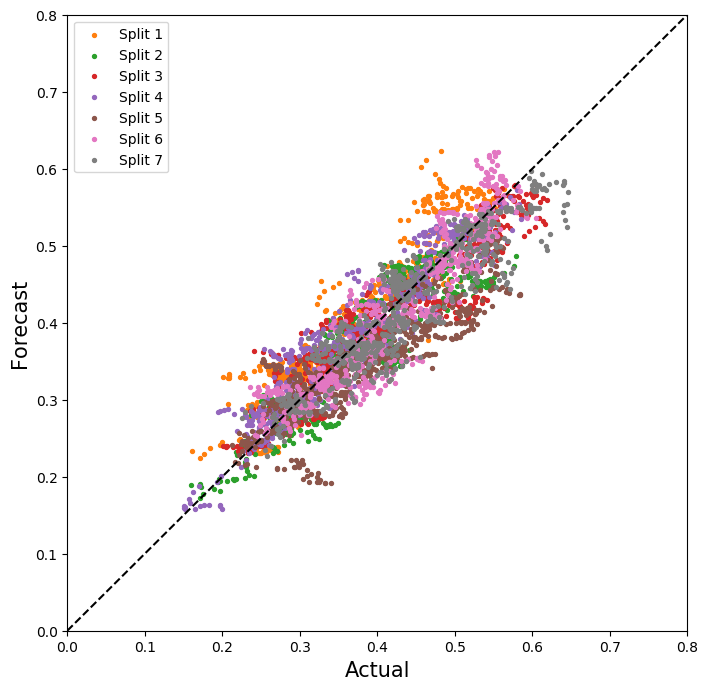

In [186]:
with plt.style.context("default"):
    for country in COUNTRIES_TO_CONSIDER:
        fig, axs = plt.subplots(figsize = (8, 8))
        axs.set_ylim([0, 1])
        axs.set_xlim([0, 1])
        # Add bisector.
        axs.plot(axs.get_xlim(), axs.get_ylim(), color = "black", linestyle = "--")

        for split_number in SPLITS_TO_USE:
            predictions = TOTAL_RESULTS[split_number]["prediction_sites"][[country]].copy()
            predictions = predictions.drop(["Naive", "lower_quantile", "upper_quantile"], axis = 1, level = 2)
            predictions = predictions/100

            def plot_scatter(group):
                gr = group[group.name[0]][group.name[1]]
                start, end = str(gr.index[0].date()), str(gr.index[-1].date())
                #label = start + " - " + end
                label = "Split %d" % (split_number)
                gr.plot.scatter(x = "FCS", y = "Forecast", s = 8, color = plt.get_cmap("tab10")(split_number), ax = axs, label = label)
                # Legend.
                handles, labels = plt.gca().get_legend_handles_labels()
                by_label = dict(zip(labels, handles))
                axs.legend(by_label.values(), by_label.keys(), loc = "best")
                axs.set_xlim(0, 0.8)
                axs.set_ylim(0, 0.8)

            predictions.groupby(axis = 1, level = [0, 1]).apply(plot_scatter)

        axs.set_xlabel("Actual", fontsize = 15)
        axs.set_ylabel("Forecast", fontsize = 15)

        fig.savefig(dir_output_test + "/scatter_%s.png" % country, bbox_inches = "tight", dpi = 300)

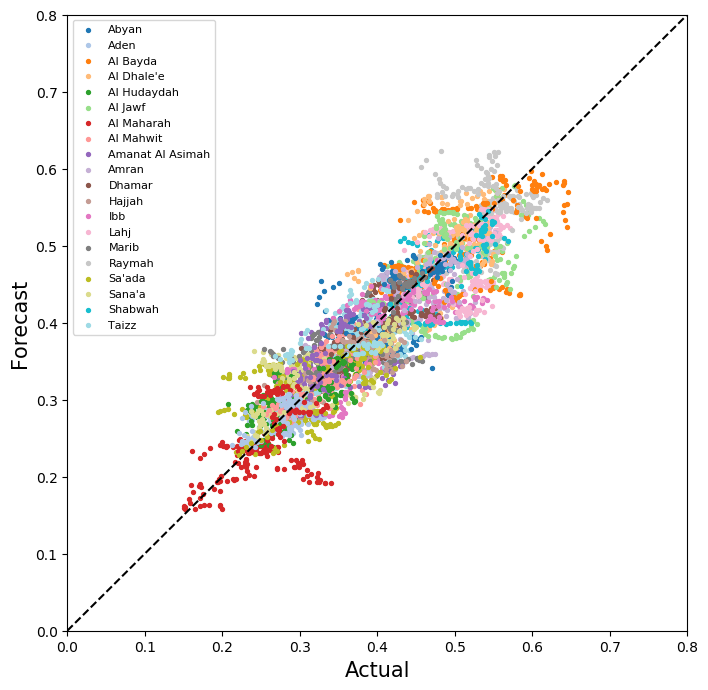

In [187]:
with plt.style.context("default"):
    for country in COUNTRIES_TO_CONSIDER:
        fig, axs = plt.subplots(figsize = (8, 8))
        axs.set_ylim([0, 1])
        axs.set_xlim([0, 1])
        # Add bisector.
        axs.plot(axs.get_xlim(), axs.get_ylim(), color = "black", linestyle = "--")

        for split_number in SPLITS_TO_USE:
            predictions = TOTAL_RESULTS[split_number]["prediction_sites"][[country]].copy()
            predictions = predictions.drop(["Naive", "lower_quantile", "upper_quantile"], axis = 1, level = 2)
            predictions = predictions/100

            def plot_scatter(group):
                gr = group[group.name[0]][group.name[1]]
                start, end = str(gr.index[0].date()), str(gr.index[-1].date())
                label = start + " - " + end
                gr.plot.scatter(x = "FCS", y = "Forecast", s = 8, color = plt.get_cmap("tab20")(predictions.columns.get_level_values(1).unique().get_loc(group.name[1])), ax = axs, label = group.name[1])

            predictions.groupby(axis = 1, level = [0, 1]).apply(plot_scatter)

            # Legend.
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            axs.legend(by_label.values(), by_label.keys(), loc = "best", prop = {"size": 8})
            axs.set_xlim(0, 0.8)
            axs.set_ylim(0, 0.8)

        axs.set_xlabel("Actual", fontsize = 15)
        axs.set_ylabel("Forecast", fontsize = 15)

        fig.savefig(dir_output_test + "/scatter2_%s.png" % country, bbox_inches = "tight", dpi = 300)

In [188]:
mStyles = ['s',"+","x","h","v","^","o"]

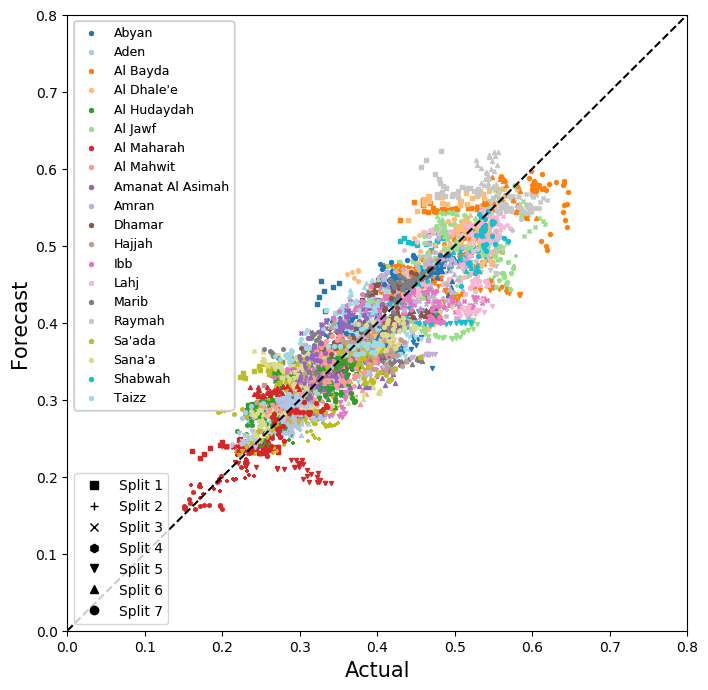

In [189]:
with plt.style.context("default"):
    for country in COUNTRIES_TO_CONSIDER:
        fig, axs = plt.subplots(figsize = (8, 8))
        axs.set_ylim([0, 1])
        axs.set_xlim([0, 1])
        # Add bisector.
        axs.plot(axs.get_xlim(), axs.get_ylim(), color = "black", linestyle = "--")

        for split_number in SPLITS_TO_USE:
            predictions = TOTAL_RESULTS[split_number]["prediction_sites"][[country]].copy()
            predictions = predictions.drop(["Naive", "lower_quantile", "upper_quantile"], axis = 1, level = 2)
            predictions = predictions/100

            def plot_scatter(group):
                gr = group[group.name[0]][group.name[1]]
                start, end = str(gr.index[0].date()), str(gr.index[-1].date())
                label = start + " - " + end
                gr.plot.scatter(x = "FCS", y = "Forecast", s = 8, marker = mStyles[split_number-1], color = plt.get_cmap("tab20")(predictions.columns.get_level_values(1).unique().get_loc(group.name[1])), ax = axs, label = group.name[1])

            predictions.groupby(axis = 1, level = [0, 1]).apply(plot_scatter)

            # Legend.
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            leg = plt.legend(by_label.values(), by_label.keys(), loc = "upper left", prop = {"size": 9})
            axs.add_artist(leg)
            h = [plt.plot([],[], color = "black", marker = mStyles[i], ls = "")[0] for i in range(len(SPLITS_TO_USE))]
            axs.legend(handles = h, labels = ["Split %d" % (i+1) for i in range(len(SPLITS_TO_USE))], loc = "lower left")
            axs.set_xlim(0, 0.8)
            axs.set_ylim(0, 0.8)

        axs.set_xlabel("Actual", fontsize = 15)
        axs.set_ylabel("Forecast", fontsize = 15)

        fig.savefig(dir_output_test + "/scatter3_%s.png" % country, bbox_inches = "tight", dpi = 300)

### Feature importance for each prediction horizon: shap

In [ ]:
split_number = 5

train, test = SPLITS[split_number]

training_points = {"X": {h+1: [] for h in range(TEST_SIZE)}, 
                   "y": {h+1: [] for h in range(TEST_SIZE)}}

for h in range(TEST_SIZE):
    for country in COUNTRIES_TO_CONSIDER:
        # Select the subdataframe corresponding to the current country.
        train_country = train[country]
        # Define the second level of multi-sites (provinces level).
        provinces = train_country.columns.get_level_values(0).unique()
        for province in provinces:
            # Training samples.
            X_train = pd.read_csv(dir_data + "/train/%s/%s/X_train_split%d_h%d.csv" % (country, province, split_number, h+1), header = [0, 1], index_col = 0) 
            y_train = pd.read_csv(dir_data + "/train/%s/%s/y_train_split%d_h%d.csv" % (country, province, split_number, h+1), header = [0, 1], index_col = 0) 

            X_train = X_train[TOTAL_RESULTS[split_number]["models"][h+1][3]]

            # Store information.
            training_points["X"][h+1].append(X_train)
            training_points["y"][h+1].append(y_train)

    training_points["X"][h+1] = pd.concat(training_points["X"][h+1]).reset_index(drop = True) 
    training_points["y"][h+1] = pd.concat(training_points["y"][h+1]).reset_index(drop = True) 

In [ ]:
# load JS visualization code to notebook.
shap.initjs()

df_shaps = list()
for h in range(TEST_SIZE):
    X = training_points["X"][h+1]

    # Explain the model's predictions using SHAP.
    explainer = shap.TreeExplainer(TOTAL_RESULTS[split_number]["models"][h+1][0])
    shap_values = explainer.shap_values(X)
    shap_values = np.abs(shap_values).mean(axis = 0)

    df_shaps.append(pd.DataFrame([shap_values], columns = [" ".join(col).strip() for col in X.columns.values]))

In [ ]:
a=pd.concat(df_shaps, axis = 0)

In [ ]:
a["Day"] = a.filter(regex = 'Day x').sum(axis = 1)
a.drop(a.filter(regex = 'Day x').columns, axis = 1, inplace = True)
a["Dayofweek"] = a.filter(regex = 'Dayofweek x').sum(axis = 1)
a.drop(a.filter(regex = 'Dayofweek x').columns, axis = 1, inplace = True)
a["Month"] = a.filter(regex = 'Month x').sum(axis = 1)
a.drop(a.filter(regex = 'Month x').columns, axis = 1, inplace = True)
a["Year"] = a.filter(regex = 'Year x').sum(axis = 1)
a.drop(a.filter(regex = 'Year x').columns, axis = 1, inplace = True)

In [ ]:
a.columns

In [ ]:
b=['FCS x(t)', 'FCS x(t-1)',
       'FCS x(t-2)', 'FCS x(t-3)', 'FCS x(t-4)', 'FCS x(t-5)', 'FCS x(t-6)',
       'FCS x(t-7)', 'FCS x(t-8)', 'FCS x(t-9)', 'rCSI x(t)', 'rCSI x(t-1)', 'rCSI x(t-2)', 'rCSI x(t-3)', 'Fatality x(t)',
       'Fatality x(t-1)', 'Fatality x(t-2)', 'Fatality x(t-3)', 'Rainfall (mm) delay', 'Rainfall (mm) x(t)', '1 Month Anomaly (%) Rainfall delay',
       '1 Month Anomaly (%) Rainfall x(t)', 'Ramadan x(t)',
       'NDVI Anomaly delay', 'NDVI Anomaly x(t)', 'Cereals and tubers delay', 'Cereals and tubers x(t)', 
       'Exchange rate delay', 'Exchange rate x(t)', 
       'Population x(t)', 'Code x(t)',
       'Day',
       'Dayofweek', 'Month', 'Year']

In [ ]:
c=a[b]
c = c.reset_index(drop = True)
c

In [ ]:
plt.pcolor(c)